In [938]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import csv

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Draw

# 1. Datasets generation

## 1.0 Function definitions

In [939]:
def split_smiles_reaction(smiles):
    if isinstance(smiles, str):  
        try:
            reactants, product = smiles.split(">>")
            
            reactants_split = reactants.split(".")
        
            if len(reactants_split) == 2:
                reactant_1, reactant_2 = reactants_split
            else:
                reactant_1 = reactants_split[0]
                reactant_2 = None  
            
            return pd.Series([reactant_1, reactant_2, product])
        
        except ValueError:
            
            return pd.Series([None, None, None])
    else:
      
        return pd.Series([None, None, None])

In [3]:
def load_and_filter_excel(file_path):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None
    
    required_columns = [
        "Reaction",
        "Reagent",
        "Time (Reaction Details) [h]",
        "Temperature (Reaction Details) [C]",
        "Pressure (Reaction Details) [Torr]",
        "pH-Value (Reaction Details)",
        "Other Conditions",
        "Yield (numerical)",
        "Catalyst",
        "Solvent (Reaction Details)",
        "Fulltext of reaction"
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    
    filtered_df = df[available_columns]

    filtered_df = filtered_df.dropna(subset=['Fulltext of reaction'])

    filtered_df = filtered_df[filtered_df['Fulltext of reaction'].str.strip() != '']

    filtered_df.fillna('unknown', inplace=True)

    filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)

    filtered_df = filtered_df.dropna(subset=['product'])

    filtered_df = filtered_df.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

    return filtered_df


In [941]:
def load_and_filter_excel_multi_corpus(file_path):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None
    
    required_columns = [
        "Reaction",
        "Reagent",
        "Time (Reaction Details) [h]",
        "Temperature (Reaction Details) [C]",
        "Pressure (Reaction Details) [Torr]",
        "pH-Value (Reaction Details)",
        "Other Conditions",
        "Yield (numerical)",
        "Catalyst",
        "Solvent (Reaction Details)",
        "Fulltext of reaction"
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None
    
    filtered_df = df[available_columns]

    filtered_df = filtered_df.dropna(subset=['Fulltext of reaction'])

    filtered_df = filtered_df[filtered_df['Fulltext of reaction'].str.strip() != '']

    filtered_df.fillna('unknown', inplace=True)

    filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)

    filtered_df = filtered_df.dropna(subset=['product'])


    return filtered_df


In [942]:
def load_and_filter_excel_cond(file_path):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None
    
    required_columns = [
        "Reaction",
        "Reagent",
        "Time (Reaction Details) [h]",
        "Temperature (Reaction Details) [C]",
        "Pressure (Reaction Details) [Torr]",
        "pH-Value (Reaction Details)",
        "Other Conditions",
        "Yield (numerical)",
        "Catalyst",
        "Solvent (Reaction Details)",
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)

    filtered_df = filtered_df.dropna(subset=['product'])

    filtered_df = filtered_df.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

    return filtered_df


In [943]:
def load_and_filter_excel_smiles(file_path):
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None
    
    required_columns = [
        "Reaction",
    ]
    
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        print("None of the required columns are available in the Excel file.")
        return None

    filtered_df = df[available_columns]

    filtered_df.fillna('unknown', inplace=True)

    filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)

    filtered_df = filtered_df.dropna(subset=['product'])

    filtered_df = filtered_df.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

    return filtered_df

In [944]:
def create_prompt_simple_corpus(row):
    return (
        f"Predict the product for the following reaction: "
        f"First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, "
        f"The reagent: {row['Reagent']}, "
        f"Temperature: {row['Temperature (Reaction Details) [C]']}°C, "
        f"Time: {row['Time (Reaction Details) [h]']} hours, "
        f"Catalyst: {row['Catalyst']}, "
        f"Solvent: {row['Solvent (Reaction Details)']}. "
        f"Other Conditions: {row['Other Conditions']}. "
        f"Also, the procedure of the reaction was the following: {row['Fulltext of reaction']}."
    )

In [945]:
def create_prompt_cond(row):
    return (
        f"Predict the product for the following reaction: "
        f"First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, "
        f"The reagent: {row['Reagent']}, "
        f"Temperature: {row['Temperature (Reaction Details) [C]']}°C, "
        f"Time: {row['Time (Reaction Details) [h]']} hours, "
        f"Catalyst: {row['Catalyst']}, "
        f"Solvent: {row['Solvent (Reaction Details)']}. "
        f"Other Conditions: {row['Other Conditions']}. "
    )

In [946]:
def create_prompt_smiles(row):
    return (
        f"Predict the product for the following reaction: "
        f"First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, "
    )

In [947]:
def create_prompt_simple_corpus_df(df):
    df_temp = pd.DataFrame()
    
    df_temp['prompt'] = df.apply(create_prompt_simple_corpus, axis=1)
    df_temp['answer'] = df['product'] 
    
    df_temp['qa_pair'] = df_temp['prompt'] + " The SMILES answer is: " + df_temp['answer'].astype(str) + "\n\n"
    
    return df_temp

In [948]:
def create_prompt_cond_df(df):
    df_temp = pd.DataFrame()
    
    df_temp['prompt'] = df.apply(create_prompt_cond, axis=1)
    df_temp['answer'] = df['product'] 
    
    df_temp['qa_pair'] = df_temp['prompt'] + " The SMILES answer is: " + df_temp['answer'].astype(str) + "\n\n"
    
    return df_temp

In [949]:
def create_prompt_smiles_df(df):
    df_temp = pd.DataFrame()
    
    df_temp['prompt'] = df.apply(create_prompt_smiles, axis=1)
    df_temp['answer'] = df['product'] 
    
    df_temp['qa_pair'] = df_temp['prompt'] + " The SMILES answer is: " + df_temp['answer'].astype(str) + "\n\n"
    
    return df_temp

## 1.1 Simple corpus approach

### From the data retrieved, let's clean the data and prepare a prompt for GPT-4

In [1348]:
df_corpus_simple = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [1349]:
df_corpus_simple.shape

(31805, 41)

In [1350]:
df_simple_corpus_filtered = load_and_filter_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [1351]:
print(df_simple_corpus_filtered.shape)

(4881, 14)


In [1352]:
df_simple_corpus_filtered = create_prompt_simple_corpus_df(df_simple_corpus_filtered)

In [1353]:
df_simple_corpus_filtered

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
5,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
9,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,Predict the product for the following reaction...
13,Predict the product for the following reaction...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,Predict the product for the following reaction...
20,Predict the product for the following reaction...,CC(=O)C=CC1=CC=CO1,Predict the product for the following reaction...
...,...,...,...
31798,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)\C=C\C1=NC2=CC=C(OC)C=C2C=...,Predict the product for the following reaction...
31799,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC=C(C=C4)N(...,Predict the product for the following reaction...
31800,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC(=CC=C4)N(...,Predict the product for the following reaction...
31801,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=C\C4=CC=NC=C4)\C...,Predict the product for the following reaction...


In [1354]:
training_data_corpus_simple = df_simple_corpus_filtered.sample(n = 4663, random_state=42)

test_data_corpus_simple = df_simple_corpus_filtered.drop(training_data_corpus_simple.index)


In [1355]:
print(training_data_corpus_simple.shape, test_data_corpus_simple.shape)

(4663, 3) (218, 3)


## 1.2 Multi-corpus approach

In [1356]:
df_multi_corpus = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [1357]:
df_multi_corpus.columns

Index(['Reaction ID', 'Reaction: Links to Reaxys', 'Data Count',
       'Number of Reaction Details', 'Reaction Rank', 'Record Type',
       'Reactant', 'Product', 'Bin', 'Reaction',
       'Reaction Details: Reaction Classification', 'Example label',
       'Example title', 'Fulltext of reaction', 'Number of Reaction Steps',
       'Multi-step Scheme', 'Multi-step Details', 'Number of Stages',
       'Solid Phase', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Reaction Type', 'Subject Studied',
       'Prototype Reaction', 'Named Reaction',
       'Type of reaction description (Reaction Details)', 'Location',
       'Comment (Reaction Details)', 'Product.1', 'Yield', 'Yield (numerical)',
       'Yield (optical)', 'Stage Reactant', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'References', 'Links to Reaxys'],
      dtype='object')

In [1358]:
df_multi_corpus_filtered = load_and_filter_excel_multi_corpus('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [1359]:
df_multi_corpus_filtered.columns

Index(['Reaction', 'Reagent', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Yield (numerical)', 'Catalyst',
       'Solvent (Reaction Details)', 'Fulltext of reaction', 'reactant_1',
       'reactant_2', 'product'],
      dtype='object')

In [1360]:
df_multi_corpus_filtered = create_prompt_simple_corpus_df(df_multi_corpus_filtered)

In [1361]:
df_multi_corpus_filtered

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
1,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
2,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
3,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
5,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
...,...,...,...
31798,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)\C=C\C1=NC2=CC=C(OC)C=C2C=...,Predict the product for the following reaction...
31799,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC=C(C=C4)N(...,Predict the product for the following reaction...
31800,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC(=CC=C4)N(...,Predict the product for the following reaction...
31801,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=C\C4=CC=NC=C4)\C...,Predict the product for the following reaction...


In [1362]:
training_data_multi_corpus = df_multi_corpus_filtered.sample(n=12509, random_state=42)

test_data_multi_corpus = df_multi_corpus_filtered.drop(training_data_multi_corpus.index)


In [1363]:
test_data_multi_corpus = df_multi_corpus_filtered.head(218)

training_data_multi_corpus = df_multi_corpus_filtered.drop(test_data_multi_corpus.index)

In [1364]:
test_data_multi_corpus

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
1,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
2,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
3,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
5,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
...,...,...,...
633,Predict the product for the following reaction...,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,Predict the product for the following reaction...
634,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...
636,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...
637,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...


In [1365]:
print(training_data_multi_corpus.shape, test_data_multi_corpus.shape)

(12509, 3) (218, 3)


## 1.3 Conditions approach

### In this case, we will only add to the SMILES the conditions variables to provide more information about the context in which the reaction happens

In [1702]:
df_cond = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [1703]:
df_cond.columns

Index(['Reaction ID', 'Reaction: Links to Reaxys', 'Data Count',
       'Number of Reaction Details', 'Reaction Rank', 'Record Type',
       'Reactant', 'Product', 'Bin', 'Reaction',
       'Reaction Details: Reaction Classification', 'Example label',
       'Example title', 'Fulltext of reaction', 'Number of Reaction Steps',
       'Multi-step Scheme', 'Multi-step Details', 'Number of Stages',
       'Solid Phase', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Reaction Type', 'Subject Studied',
       'Prototype Reaction', 'Named Reaction',
       'Type of reaction description (Reaction Details)', 'Location',
       'Comment (Reaction Details)', 'Product.1', 'Yield', 'Yield (numerical)',
       'Yield (optical)', 'Stage Reactant', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'References', 'Links to Reaxys'],
      dtype='object')

In [1704]:
df_cond_filtered = load_and_filter_excel_cond('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/703195588.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/703195588.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/703195588.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [1705]:
df_cond_filtered.columns

Index(['Reaction', 'Reagent', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Yield (numerical)', 'Catalyst',
       'Solvent (Reaction Details)', 'reactant_1', 'reactant_2', 'product'],
      dtype='object')

In [1706]:
df_cond_filtered = create_prompt_cond_df(df_cond_filtered)

In [1707]:
df_cond_filtered

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
5,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
9,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,Predict the product for the following reaction...
13,Predict the product for the following reaction...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,Predict the product for the following reaction...
18,Predict the product for the following reaction...,CC(=O)C=CC1=CC=CO1,Predict the product for the following reaction...
...,...,...,...
31798,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)\C=C\C1=NC2=CC=C(OC)C=C2C=...,Predict the product for the following reaction...
31799,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC=C(C=C4)N(...,Predict the product for the following reaction...
31800,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC(=CC=C4)N(...,Predict the product for the following reaction...
31801,Predict the product for the following reaction...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=C\C4=CC=NC=C4)\C...,Predict the product for the following reaction...


In [1708]:
#Setting up the training set

training_data_cond = df_cond_filtered.sample(frac=0.956, random_state=42)

# The remaining 20% can be used for testing/validation
test_data_cond = df_cond_filtered.drop(training_data_cond.index)



In [1709]:
test_data_cond

,prompt,answer,qa_pair
537,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,Predict the product for the following reaction...
1494,Predict the product for the following reaction...,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,Predict the product for the following reaction...
2728,Predict the product for the following reaction...,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,Predict the product for the following reaction...
3206,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,Predict the product for the following reaction...
3478,Predict the product for the following reaction...,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,Predict the product for the following reaction...
...,...,...,...
31663,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,Predict the product for the following reaction...
31719,Predict the product for the following reaction...,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,Predict the product for the following reaction...
31732,Predict the product for the following reaction...,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,Predict the product for the following reaction...
31740,Predict the product for the following reaction...,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,Predict the product for the following reaction...


In [1711]:
print(training_data_cond.shape, test_data_cond.shape)

(4727, 3) (218, 3)


### 1.4 SMILES only approach

### Let's just try to simple SMILES approach

In [977]:
df_smiles = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

In [978]:
df_smiles.columns

Index(['Reaction ID', 'Reaction: Links to Reaxys', 'Data Count',
       'Number of Reaction Details', 'Reaction Rank', 'Record Type',
       'Reactant', 'Product', 'Bin', 'Reaction',
       'Reaction Details: Reaction Classification', 'Example label',
       'Example title', 'Fulltext of reaction', 'Number of Reaction Steps',
       'Multi-step Scheme', 'Multi-step Details', 'Number of Stages',
       'Solid Phase', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Reaction Type', 'Subject Studied',
       'Prototype Reaction', 'Named Reaction',
       'Type of reaction description (Reaction Details)', 'Location',
       'Comment (Reaction Details)', 'Product.1', 'Yield', 'Yield (numerical)',
       'Yield (optical)', 'Stage Reactant', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'References', 'Links to Reaxys'],
      dtype='object')

In [979]:
df_smiles_filtered = load_and_filter_excel_smiles('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/Reaxys_Exp_test3.xlsx')

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/1435803462.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna('unknown', inplace=True)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/1435803462.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['reactant_1', 'reactant_2', 'product']] = df['Reaction'].apply(split_smiles_reaction)
/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/1435803462.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [980]:
df_smiles_filtered.columns

Index(['Reaction', 'reactant_1', 'reactant_2', 'product'], dtype='object')

In [981]:
df_smiles_filtered = create_prompt_smiles_df(df_smiles_filtered)

In [982]:
df_smiles_filtered.columns

Index(['prompt', 'answer', 'qa_pair'], dtype='object')

In [983]:
training_data_smiles = df_smiles_filtered.sample(frac=0.956, random_state=42)

test_data_smiles = df_smiles_filtered.drop(training_data_smiles.index)

In [984]:
print(training_data_smiles.shape, test_data_smiles.shape)

(4727, 3) (218, 3)


# 2. ChatGPT 4 (API call): Prompting

In [985]:
import openai
from openai import OpenAI

In [366]:
# First API key
client0 = OpenAI(api_key='')  

In [404]:
# New API key
client = OpenAI(api_key='')

In [403]:
import tiktoken
import pandas as pd

encoding = tiktoken.encoding_for_model("gpt-4")

df = pd.DataFrame()

def count_tokens(text):
    return len(encoding.encode(text))

"""
df['token_count_smiles'] = df_smiles_filtered['prompt'].apply(count_tokens)
df['token_count_cond'] = df_cond_filtered['prompt'].apply(count_tokens)
df['token_count_corpus'] = df_simple_corpus_filtered['prompt'].apply(count_tokens)

"""

df['token_count_smiles'] = test_data_smiles['prompt'].apply(count_tokens)
df['token_count_cond'] = test_data_cond['prompt'].apply(count_tokens)
df['token_count_corpus'] = test_data_corpus_simple['prompt'].apply(count_tokens)
df['token_count_corpus_multi'] = test_data_multi_corpus['prompt'].apply(count_tokens)

total_tokens_smiles = df['token_count_smiles'].sum()
total_tokens_cond = df['token_count_cond'].sum()
total_tokens_corpus = df['token_count_corpus'].sum()
total_tokens_corpus_multi = df['token_count_corpus_multi'].sum()

count_few_shot = count_tokens(prompt_smiles_training_5)

count_few_shot_m = count_tokens(prompt__multi_corpus_training_15)

print(f"Total number of tokens in the SMILES test set: {total_tokens_smiles}")
print(f"Total number of tokens in the cond test set: {total_tokens_cond}")
print(f"Total number of tokens in the corpus test set: {total_tokens_corpus}")
print(f"Total number of tokens in the multi corpus test set: {total_tokens_corpus_multi}")

print(f"Total number of tokens in the few shot set: {count_few_shot}")

print(f"Total number of tokens in the few shot set for multi corpus: {count_few_shot_m}")



Total number of tokens in the SMILES test set: 11165
Total number of tokens in the cond test set: 18039
Total number of tokens in the corpus test set: 11299.0
Total number of tokens in the multi corpus test set: 1484.0
Total number of tokens in the few shot set: 451
Total number of tokens in the few shot set for multi corpus: 5446


In [707]:
test_data_multi_corpus.reset_index(drop=True, inplace=True) 

In [736]:
test_data_multi_corpus.iloc[:,2][29]

'Predict the product for the following reaction: First reactant: OC1=CC=C(C=O)C=C1, second reactant: CCOC(=O)CC#N, Temperature: 20°C, Time: 0.333333 hours, Catalyst: unknown, Solvent: neat (no solvent). Other Conditions: Green chemistry. Also, the procedure of the reaction was the following: General procedure: A round bottom flask was charged with aryl aldehyde (10 mmol), 2,4-thiazolidinedione (10 mmol) and ionic liquid (2 mmol). The reaction mixture was stirred and monitored by TLC. Upon completion, water was added and the mixture was stirred. The mixture was allowed to stand to separate into two layers, affording the product and ionic liquid. The separated solid product was suction-filtered and further purified by crystallization from hot EtOH. The filtrate containing the ionic liquid was then evaporated under reduced pressure, and the ionic liquid was reused directly for the next run. The melting point and spectra data of products are given as below.. The SMILES answer is: CCOC(=O)C

In [211]:
def generate_few_shot_examples(df, n_examples):

    selected_qanda = df['qa_pair'].head(n_examples)
    
    few_shot_examples = "\n\n".join(selected_qanda)
    
    return few_shot_examples

In [761]:
training_data_multi_corpus.reset_index(drop = True, inplace =True)

In [791]:
def generate_few_shot_examples_mc(df):
  
    selected_qanda = df['qa_pair'].iloc[[0, 1, 6, 7,9,10,27,28,45,46]]


    few_shot_examples = "\n\n".join(selected_qanda)

    return few_shot_examples

In [409]:
def get_chatgpt_response_nopriming(row, str_fs):
   
    try:
        user_message = (
            f"Provide only the SMILES representation for the following question, without any explanation or extra text:\n\n"
            f"This is the few-shot training you can use:\n\n"
            f"{str_fs}\n\n"
            f"Now, for the new question:\n\n"
            f"Q: {row}\nA:"
        )

        response = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": ""},
                {"role": "user", "content": user_message}
            ],
            max_tokens=100,  
            temperature=0.15  
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"


In [442]:
def get_chatgpt_response_priming(row, str_fs):
    
    try:
        
        user_message = (
            f"Provide only the SMILES representation for the following question, without any explanation or extra text:\n\n"
            f"This is the few-shot training you can use:\n\n"
            f"{str_fs}\n\n"
            f"Now, for the new question:\n\n"
            f"Q: {row}\nA:"
        )

      
        response = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are an expert in organic chemistry specialized in aldol-type chemical reactions."},
                {"role": "user", "content": user_message}
            ],
            max_tokens=100,  
            temperature=0.15 
        )

        
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"


In [160]:
def create_few_shot_prompt(df):

    prompt = ""
    
    for i in range(df.shape[0]):
        prompt += f"Q: {df.iloc[i]['prompt']}\nA: {df.iloc[i]['answer']}\n\n"
    
    return prompt

In [986]:
prompt_smiles = create_few_shot_prompt(df_smiles_filtered)
prompt_cond = create_few_shot_prompt(df_cond_filtered)
prompt_corpus = create_few_shot_prompt(df_simple_corpus_filtered)

prompt_smiles_training = create_few_shot_prompt(training_data_smiles)
prompt_cond_training = create_few_shot_prompt(training_data_cond)
prompt_corpus_training = create_few_shot_prompt(training_data_corpus_simple)

prompt_smiles_test = create_few_shot_prompt(test_data_smiles)
prompt_cond_test = create_few_shot_prompt(test_data_cond)
prompt_corpus_test = create_few_shot_prompt(test_data_corpus_simple)

In [987]:
training_data_multi_corpus.sort_index(inplace=True)

In [988]:
prompt_smiles_training_5 = generate_few_shot_examples(training_data_smiles, 5)
prompt_cond_training_5 = generate_few_shot_examples(training_data_cond, 5)
prompt_corpus_training_5 = generate_few_shot_examples(training_data_corpus_simple, 5)
prompt__multi_corpus_training_15 = generate_few_shot_examples_mc(training_data_multi_corpus)


In [989]:
prompt__multi_corpus_training_15

"Predict the product for the following reaction: First reactant: O=CC1=CC=C2OCOC2=C1, second reactant: CC(=O)C1=CC=CC=C1, The reagent: sodium hydroxide, Temperature: 20°C, Time: 0.0833333 - 0.116667 hours, Catalyst: unknown, Solvent: neat (no solvent). Other Conditions: Milling; Green chemistry. Also, the procedure of the reaction was the following: General procedure: A mixture of Piperonal (0.005 mol), substituted acetophenone (0.005 mol) and solid pellet of NaOH (0.005 mol) 200mg was ground thoroughly with a pestle in an open mortarat room temperature for 5-7 minutes. The completion ofthe reaction was monitored by TLC using n-hexane-ethylacetate (2:1) as eluent. On completion of the grinding as monitored by TLC, the obtained solid mixture was washed with water and recrystallized from ethanol.. The SMILES answer is: O=C(\\C=C\\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1\n\n\n\nPredict the product for the following reaction: First reactant: O=CC1=CC=C2OCOC2=C1, second reactant: CC(=O)C1=CC=CC=C1, T

### 2.1 SMILES only with priming results

In [990]:
test_data_smiles['SMILES_pred'] = ""

for index, row in test_data_smiles.iterrows():

    result = get_chatgpt_response_priming(row['prompt'], prompt_smiles_training_5)
    
    test_data_smiles.at[index, 'SMILES_pred'] = result



In [991]:
test_data_smiles

,prompt,answer,qa_pair,SMILES_pred
537,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,Predict the product for the following reaction...,O=C1CCCCC1C(=O)C1CCCCC1
1494,Predict the product for the following reaction...,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,Predict the product for the following reaction...,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C2C1=O
2728,Predict the product for the following reaction...,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,Predict the product for the following reaction...,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1
3206,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
3478,Predict the product for the following reaction...,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,Predict the product for the following reaction...,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...,...,...
31663,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
31719,Predict the product for the following reaction...,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,Predict the product for the following reaction...,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(CC(C)(C)...
31732,Predict the product for the following reaction...,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,Predict the product for the following reaction...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
31740,Predict the product for the following reaction...,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,Predict the product for the following reaction...,COC1=C(C(=O)C)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


### 2.2 SMILES only with no priming


In [460]:
test_data_smiles['SMILES_pred'] = ""

for index, row in test_data_smiles.iterrows():

    result = get_chatgpt_response_nopriming(row['prompt'], prompt_smiles_training_5)
    
    test_data_smiles.at[index, 'SMILES_pred'] = result

print(test_data_smiles)


                                                  prompt  \
537    Predict the product for the following reaction...   
1494   Predict the product for the following reaction...   
2728   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31663  Predict the product for the following reaction...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1494             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2728                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

### 2.3 Conditions with priming


In [1712]:
test_data_cond['SMILES_pred'] = ""

for index, row in test_data_cond.iterrows():

    result = get_chatgpt_response_priming(row['prompt'], prompt_cond_training_5)
    
    test_data_cond.at[index, 'SMILES_pred'] = result

print(test_data_cond)

                                                  prompt  \
537    Predict the product for the following reaction...   
1494   Predict the product for the following reaction...   
2728   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31663  Predict the product for the following reaction...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1494             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2728                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

### 2.4 Conditions with no priming

In [1008]:
test_data_cond['SMILES_pred'] = ""

for index, row in test_data_cond.iterrows():

    result = get_chatgpt_response_nopriming(row['prompt'], prompt_cond_training_5)
    
    test_data_cond.at[index, 'SMILES_pred'] = result

print(test_data_cond)

                                                  prompt  \
537    Predict the product for the following reaction...   
1494   Predict the product for the following reaction...   
2728   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31663  Predict the product for the following reaction...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1494             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2728                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

### 2.5 Simple corpus with no priming

In [1016]:
test_data_corpus_simple['SMILES_pred'] = ""

for index, row in test_data_corpus_simple.iterrows():

    result = get_chatgpt_response_nopriming(row['prompt'], prompt_corpus_training_5)
    
    test_data_corpus_simple.at[index, 'SMILES_pred'] = result

print(test_data_corpus_simple)

                                                  prompt  \
537    Predict the product for the following reaction...   
1496   Predict the product for the following reaction...   
2730   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31753  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1496             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2730                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

### 2.7 Simple corpus with priming

In [1023]:
test_data_corpus_simple['SMILES_pred'] = ""

for index, row in test_data_corpus_simple.iterrows():

    result = get_chatgpt_response_priming(row['prompt'], prompt_corpus_training_5)
    
    test_data_corpus_simple.at[index, 'SMILES_pred'] = result

print(test_data_corpus_simple)

                                                  prompt  \
537    Predict the product for the following reaction...   
1496   Predict the product for the following reaction...   
2730   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31753  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1496             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2730                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

### 2.8 Multi corpus no priming


In [1031]:
test_data_multi_corpus['SMILES_pred'] = ""

for index, row in test_data_multi_corpus.iterrows():

    result = get_chatgpt_response_nopriming(row['prompt'], prompt__multi_corpus_training_15)
    
    test_data_multi_corpus.at[index, 'SMILES_pred'] = result

print(test_data_multi_corpus)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/3426457244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_multi_corpus['SMILES_pred'] = ""


                                                prompt  \
0    Predict the product for the following reaction...   
1    Predict the product for the following reaction...   
2    Predict the product for the following reaction...   
3    Predict the product for the following reaction...   
5    Predict the product for the following reaction...   
..                                                 ...   
633  Predict the product for the following reaction...   
634  Predict the product for the following reaction...   
636  Predict the product for the following reaction...   
637  Predict the product for the following reaction...   
641  Predict the product for the following reaction...   

                                                answer  \
0    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
1    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
2    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
3    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
5    COC1=CC=

### 2.9 Multi corpus with priming

In [1039]:
test_data_multi_corpus['SMILES_pred'] = ""

for index, row in test_data_multi_corpus.iterrows():

    result = get_chatgpt_response_priming(row['prompt'], prompt__multi_corpus_training_15)
    
    test_data_multi_corpus.at[index, 'SMILES_pred'] = result

print(test_data_multi_corpus)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/2981113993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_multi_corpus['SMILES_pred'] = ""


                                                prompt  \
0    Predict the product for the following reaction...   
1    Predict the product for the following reaction...   
2    Predict the product for the following reaction...   
3    Predict the product for the following reaction...   
5    Predict the product for the following reaction...   
..                                                 ...   
633  Predict the product for the following reaction...   
634  Predict the product for the following reaction...   
636  Predict the product for the following reaction...   
637  Predict the product for the following reaction...   
641  Predict the product for the following reaction...   

                                                answer  \
0    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
1    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
2    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
3    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
5    COC1=CC=

# 3. Tamonimoto Similarity SMILES check

### In this part, the Tanimoto metric will be calculated to access the similarity between the true and predicted SMILES

### 3.1 Function definitions

In [293]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors

In [294]:
def smiles_to_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES: {smiles}")
            return None
    
        generator = rdMolDescriptors.GetMorganFingerprintAsBitVect
        fingerprint = generator(mol, radius=2, nBits=2048)
        
        return fingerprint
    except Exception as e:
        print(f"Error generating fingerprint for {smiles}: {e}")
        return None

def compute_tanimoto(smiles_pred, smiles_true):
    fp1 = smiles_to_fingerprint(smiles_pred)
    fp2 = smiles_to_fingerprint(smiles_true)
    
    if fp1 is None or fp2 is None:
        return None
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [295]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  
    except:
        return False  

def filter_invalid_smiles(df, smiles_column='SMILES_pred'):

    df_filtered = df[df[smiles_column].apply(is_valid_smiles)]
    
    return df_filtered

In [296]:
def tanim_avg(df):

    total = 0
    count = 0

    for i in df.iloc[:,2]:

        if pd.isna(i):
            total += 0
            count += 0
        else:
            total += i
            count += 1
    
    return total/count

In [297]:
def tanim_count_perfpred(df):

    count = 0

    for i in df['tanimoto_similarity']:

        if i == 1:
            
            count += 1 
    
    return f"The number of perfectly predicted SMILES (with Tanimoto score of 1) is {count}"
            


In [301]:
def df_prep_tanim(df):
    name = pd.DataFrame({'SMILES_true': df['answer'], 'SMILES_pred': df['SMILES_pred']})
    name.reset_index(drop=True, inplace=True)
    return name

### 3.2 SMILES only with priming

In [992]:
df_smiles_tanim = df_prep_tanim(test_data_smiles)

In [993]:
df_smiles_tanim

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1CCCCC1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C2C1=O
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(CC(C)(C)...
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
216,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(=O)C)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


In [994]:
df_smiles_tanim_filtered = filter_invalid_smiles(df_smiles_tanim, 'SMILES_pred')

[10:39:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[10:39:26] SMILES Parse Error: syntax error while parsing: COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H
[10:39:26] SMILES Parse Error: Failed parsing SMILES 'COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H'
[10:39:26] SMILES Parse Error: unclosed ring for input: 'FC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=O)C(C)=O'
[10:39:26] Explicit valence for atom # 17 C, 5, is greater than permitted
[10:39:26] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=O)=CC=C1O\C=C\C1=CC=C(O)C(=O)C1=C(C)C=C1'
[10:39:26] Explicit valence for atom # 10 O, 3, is greater than permitted
[10:39:26] Explicit valence for atom # 12 O, 3, is greater than permitted
[10:39:26] Explicit valence for atom # 16 C, 5, is greater than permitted
[10:39:26] Explicit valence for atom # 6 O, 3, is greater than permitted
[10:39:26] Explicit valence for atom # 8 N, 4, is greater than permi

In [995]:
df_smiles_tanim_filtered

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1CCCCC1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C2C1=O
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
211,[H][C@@]12CC[C@H](C(=O)\C=C\C3=CC=CC=C3)[C@@]1...,[H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(CC(C)(C)...
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...


In [996]:
df_smiles_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_smiles_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerator
[10:39:29] DEPRECATION WARNING: please use MorganGenerat

In [997]:
df_smiles_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1CCCCC1,0.122449
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C2C1=O,0.246154
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1,0.318182
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1,0.800000
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O,0.551020
...,...,...,...
211,[H][C@@]12CC[C@H](C(=O)\C=C\C3=CC=CC=C3)[C@@]1...,[H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...,0.513158
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F,1.000000
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(CC(C)(C)...,0.186441
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...,0.613333


In [998]:
tanim_avg(df_smiles_tanim_filtered)

0.4442682190091106

In [999]:
tanim_count_perfpred(df_smiles_tanim_filtered)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 9'

### 3.3 SMILES only no priming


In [461]:
df_smiles_tanim_np = df_prep_tanim(test_data_smiles)

In [462]:
df_smiles_tanim_np 

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1CCC2=C1C=CC=C2
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(C)(C)OC(=O)OC(=O)N(O)
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
216,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(C)=O)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


In [463]:
df_smiles_tanim_filtered_np = filter_invalid_smiles(df_smiles_tanim_np, 'SMILES_pred')

[12:12:48] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:12:48] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:12:48] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=CS1\C=C\C1=CC=C(C(=O)O)C1=CC=CC=C1'
[12:12:48] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:12:48] Explicit valence for atom # 17 C, 5, is greater than permitted
[12:12:48] Explicit valence for atom # 10 O, 3, is greater than permitted
[12:12:48] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=CO1\C=C\C1=CC=C(S)C(=O)C1=CC=CO1'
[12:12:48] Explicit valence for atom # 8 N, 4, is greater than permitted
[12:12:48] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=C2OCCC2=C1\C=C\C1=CC=C(Br)C(=O)C1=C(C)C=C1'
[12:12:48] Explicit valence for atom # 9 O, 3, is greater than permitted
[12:12:48] Explicit valence for atom # 9 C, 5, is greater than permitted
[12:12:48] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:12:48] SMILES Parse Erro

In [464]:
df_smiles_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_smiles_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerator
[12:12:51] DEPRECATION WARNING: please use MorganGenerat

In [465]:
df_smiles_tanim_filtered_np

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O),0.159091
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1CCC2=C1C=CC=C2,0.306452
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C(=O)C)C=C1,0.318182
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1,0.800000
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O,0.551020
...,...,...,...
211,[H][C@@]12CC[C@H](C(=O)\C=C\C3=CC=CC=C3)[C@@]1...,[H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...,0.513158
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F,1.000000
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(C)(C)OC(=O)OC(=O)N(O),0.180000
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...,0.613333


In [466]:
tanim_avg(df_smiles_tanim_filtered_np)

0.4407096328773639

In [467]:
tanim_count_perfpred(df_smiles_tanim_filtered_np)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 9'

### 3.4 Conditions with no priming


In [1009]:
df_cond_tanim_np = df_prep_tanim(test_data_cond)

In [1010]:
df_cond_tanim_np

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2=C1C=CC=C2
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C=O)C=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(C)C(C)(C)C
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
216,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(=O)C)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


In [1011]:
df_cond_tanim_filtered_np = filter_invalid_smiles(df_cond_tanim_np, 'SMILES_pred')

[10:53:00] Explicit valence for atom # 17 C, 5, is greater than permitted
[10:53:00] Explicit valence for atom # 6 N, 4, is greater than permitted
[10:53:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:53:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:53:00] SMILES Parse Error: syntax error while parsing: CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H
[10:53:00] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H'
[10:53:00] Explicit valence for atom # 9 O, 3, is greater than permitted
[10:53:00] Explicit valence for atom # 8 O, 3, is greater than permitted
[10:53:00] Explicit valence for atom # 6 O, 3, is greater than permitted
[10:53:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[10:53:00] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=C2OCCC2=C1\C=C\C1=CC=C(Br)C(=O)C1=C(C)C=C1'
[10:53:00] Explicit valence for atom # 16 O

In [1012]:
df_cond_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerator
[10:53:02] DEPRECATION WARNING: please use MorganGenerat

In [1013]:
df_cond_tanim_filtered_np

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1,0.160000
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C=O)C=C1,0.318182
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1,0.800000
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O,0.551020
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CC(C=O)=C1OC,0.520833
...,...,...,...
209,COC(=O)C(CO)C(O)(CCO[Si](C)(C)C(C)(C)C)\C=C\C,COC(=O)CC(O)C\C=C\C(=O)CCO[Si](C)(C)C(C)(C)C,0.362069
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F,1.000000
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)N(C)C(C)(C)C,0.224490
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...,0.613333


In [1014]:
tanim_avg(df_cond_tanim_filtered_np)

0.4563362310337291

In [1015]:
tanim_count_perfpred(df_cond_tanim_filtered_np)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 9'

### 3.5 Conditions with priming

In [1713]:
df_cond_tanim = df_prep_tanim(test_data_cond)

In [1714]:
df_cond_tanim

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1\C=C\C1=CC=CC=C1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C1C2=O
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C=O)C=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)NO
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
216,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(C)=O)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


In [1715]:
df_cond_tanim_filtered = filter_invalid_smiles(df_cond_tanim, 'SMILES_pred')

[17:40:46] Explicit valence for atom # 7 C, 5, is greater than permitted
[17:40:46] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(=O)C1=CC=CC=C1)C(O)C(=O)C1=CC=CC=C1'
[17:40:46] SMILES Parse Error: syntax error while parsing: CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H
[17:40:46] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H'
[17:40:46] SMILES Parse Error: unclosed ring for input: 'BrC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C2=C1C=CC=C2'
[17:40:46] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:40:46] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:40:46] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=O)=CC=C1O\C=C\C1=CC(=O)NCC#N'
[17:40:46] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=CO1\C=C\C1=CC=C(S)C(=O)C1=CC=CC=C1'
[17:40:46] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:40:46] SMILES Parse Erro

In [1716]:
df_cond_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerator
[17:40:48] DEPRECATION WARNING: please use MorganGenerat

In [1717]:
df_cond_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1\C=C\C1=CC=CC=C1,0.200000
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CC=C2C=CC=C1C2=O,0.246154
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=C(C=O)C=C1,0.318182
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1,0.800000
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O,0.551020
...,...,...,...
211,[H][C@@]12CC[C@H](C(=O)\C=C\C3=CC=CC=C3)[C@@]1...,[H]C(=O)C1=CC=CC=C1\C=C\C[C@@]12CC[C@H](C(C)=O...,0.419753
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F,1.000000
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)NO,0.183673
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...,0.613333


In [1718]:
tanim_avg(df_cond_tanim_filtered)

0.46888957692796995

In [1719]:
tanim_count_perfpred(df_cond_tanim_filtered)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 12'

### 3.6 Corpus with no priming

In [1017]:
df_corpus_simple_tanim_np = df_prep_tanim(test_data_corpus_simple)

In [1018]:
df_corpus_simple_tanim_np

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,OC1=CCCCC1C(=O)C2=CC=CC=C2N(CC)CC
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC2=C1C=CC=C2
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,OC(=O)C1=C(O)C=CC=C1C(=O)C1=CC(=CC=C1)N(=O)=O
...,...,...
213,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C(=O)OC(C)(C)C)C(=O)OC(=O)NO)C(C)(C)C
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1C1=CC...
215,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(C)=O)C(O)=C(CC=C)C2=C1C=CO2C1=CC=CC=C...
216,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,CCOC(=O)C(F)(F)C(=O)C=CC1=CC=C(Cl)C=C1C(C)=O


In [1019]:
df_corpus_simple_tanim_filtered_np = filter_invalid_smiles(df_corpus_simple_tanim_np, 'SMILES_pred')

[10:58:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:58:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:58:00] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=CC=C1)C(=O)C=C(C=C1)C1=CC=CC=C1'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(C=C1)C(=O)C2=C(OCOC2)C=CC(=C2)C=O'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'OC1=C(NC(=O)C2=C1C(=O)C=C2)C=C(C)C=C1C(=O)C1=CC=C(C)C=C1'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(C=C1)C(=O)C1=CC=C(C(OC)=C1)C(OC)=C1'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'C1=CC=CC=C1C(=O)C=CC1=CC=C(C1C(=C(C)C(=O)C)C)C=C1'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=CC=C1)C(=O)C2=C(C=CC=C2)C=C1C=CC=CC2'
[10:58:00] SMILES Parse Error: unclosed ring for input: 'CC1=CC=C(C=C1)C(=O)C=C(C=CC=N1)C=O'
[10:58:00] SMILES Parse Error: extra open parentheses for input: 'OC1=C(C=O)C=C(C=C1)C(=C)C1=CC=C(C=CC1)C(Cl)C(=O)C1=CC=C(C=C1)C(=O)C

In [1020]:
df_corpus_simple_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_corpus_simple_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)
df_corpus_simple_tanim_filtered_np

[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerat

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,OC1=CCCCC1C(=O)C2=CC=CC=C2N(CC)CC,0.228070
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC2=C1C=CC=C2,0.339623
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1,0.575758
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O,0.404255
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,OC(=O)C1=C(O)C=CC=C1C(=O)C1=CC(=CC=C1)N(=O)=O,0.460000
...,...,...,...
212,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,FC(F)(F)C1=CC=C(C=C1)C(=O)C1=CC=C(C=C1)C(C)=O,0.404762
213,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C(=O)OC(C)(C)C)C(=O)OC(=O)NO)C(C)(C)C,0.222222
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1C1=CC...,0.545455
216,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,CCOC(=O)C(F)(F)C(=O)C=CC1=CC=C(Cl)C=C1C(C)=O,0.301205


In [1021]:
tanim_avg(df_corpus_simple_tanim_filtered_np)

0.3466191256741982

In [1022]:
tanim_count_perfpred(df_corpus_simple_tanim_filtered_np)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0'

### 3.7 Corpus with priming

In [1024]:
df_corpus_simple_tanim = df_prep_tanim(test_data_corpus_simple)

In [1025]:
df_corpus_simple_tanim

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC=CC2=C1C=CC=C2
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,OC1=C(C=CC(=C1)C(=O)C=C)C(=O)C=C(C)C1=CC(=C1)N...
...,...,...
213,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C(=O)OC(C)(C)C)C(=O)OC(=O)NO)C)C
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1C1=CC...
215,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(=O)C)C(O)=C(CC=C)C2=C1C=CO2C1=CC=CC=C...
216,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,CCOC(=O)C(F)(F)C(=O)C=CC1=CC=C(Cl)C=C1C(C)=O


In [1026]:
df_corpus_simple_tanim_filtered = filter_invalid_smiles(df_corpus_simple_tanim, 'SMILES_pred')

[11:05:07] Explicit valence for atom # 7 N, 4, is greater than permitted
[11:05:07] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)C=C(C1=CC=C(C=O)C=C1)C1=C[N]#N'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(C=C1)C(=O)C2=C(OCOC2)C=CC(=C2)C(=O)C1=CC=CC=C1'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'OC1=C(NC(=O)C2=C1C(=O)C=C2)C=C(C)C=C1C(=O)C1=CC=C(C)C=C1'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=CC=C(C=C1)C(=O)C=C(CSC(SC)C)C=C1'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'O=C(C1=CC=CS1)C=CC=C1'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'OC1=CC=CC=C1C(=O)C2=C(C1)C=CC=C2'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'OC1=C(Br)C=C(C=C1)C(=O)C2=CC=COC2=C1'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'O=C1C=CC=C1C2=C(SC=C2)C(=O)C1=C(C=CC=C1)C=CC=C2'
[11:05:07] SMILES Parse Error: unclosed ring for input: 'OC1=C(Cl)C=C(C=C1)C(=O)C2=CC=CC=N2C(=O)C1=C2C=CC=C1'
[11:05:07] Explicit

In [1027]:
df_corpus_simple_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_corpus_simple_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerator
[11:05:08] DEPRECATION WARNING: please use MorganGenerat

In [1028]:
df_corpus_simple_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1,0.160000
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC=CC2=C1C=CC=C2,0.290909
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1,0.514286
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O,0.404255
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,OC1=C(C=CC(=C1)C(=O)C=C)C(=O)C=C(C)C1=CC(=C1)N...,0.295082
...,...,...,...
209,O=C(C=CC1=CC(=CC=C1)N(=O)=O)C1=NC=CC=C1,OC1=C(N=O)C=C(C=C1)C(=O)C1=CC=CC=N1,0.303571
212,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,FC(F)(F)C1=CC=C(C=C1)C(=O)C1=CC=C(C=C1)C(C)=O,0.404762
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1C1=CC...,0.545455
216,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,CCOC(=O)C(F)(F)C(=O)C=CC1=CC=C(Cl)C=C1C(C)=O,0.301205


In [1029]:
tanim_avg(df_corpus_simple_tanim_filtered)

0.35413161791185305

In [1030]:
tanim_count_perfpred(df_corpus_simple_tanim_filtered)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0'

### 3.8 Multi-Corpus no priming

In [1032]:
df_multi_corpus_tanim_np = df_prep_tanim(test_data_multi_corpus)

In [1033]:
df_multi_corpus_tanim_np

,SMILES_true,SMILES_pred
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(C...
1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(C...
2,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C(=O)C1=O)C=C1ClC=C2
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=C...
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(COC1=CC=C(C=C1)C(=O...
...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC(OC)=C(C(=O)C...
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1


In [1034]:
df_multi_corpus_tanim_filtered_np = filter_invalid_smiles(df_multi_corpus_tanim_np, 'SMILES_pred')

[11:09:57] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(Cl)C=C1'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(Cl)C=C1'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C(=O)C1=O)C=C1ClC=C2'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C(=O)C(C)OC1=C(C=C2)C=C1)C=C2'
[11:09:57] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:09:57] SMILES Parse Error: unclosed ring for input: 'O=C(C=C(C1=CC=CO1)C(C)C)C=C1'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=CC=C1)C(=O)C=C1'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=CC=C1)C(=O)C=C1'
[11:09:57] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=CC=C1)C(=O)C1=CC=C(C=C1)C=C1'
[11:09:57] SMILES Parse Error: extra open parentheses for input: 'CN(C)C1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)C(C)C(C)C(C)C(C)C(C)C(C)C(C)C(C)C(C)

In [1035]:
df_multi_corpus_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_multi_corpus_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerator
[11:09:59] DEPRECATION WARNING: please use MorganGenerat

In [1036]:
df_multi_corpus_tanim_filtered_np

,SMILES_true,SMILES_pred,tanimoto_similarity
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=C...,0.223881
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(COC1=CC=C(C=C1)C(=O...,0.177215
6,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,0.372093
7,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,0.372093
8,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C(C=C\C1=CC=CC=C1)C(=O)N1[C@H](CC2=CC=CC=C2)...,0.566667
...,...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC(OC)=C(C(=O)C...,0.660000
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000


In [1037]:
tanim_avg(df_multi_corpus_tanim_filtered_np)

0.42857459649033064

In [1038]:
tanim_count_perfpred(df_multi_corpus_tanim_filtered_np)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 12'

### Multi-Corpus priming

In [1040]:
df_multi_corpus_tanim = df_prep_tanim(test_data_multi_corpus)

In [1041]:
df_multi_corpus_tanim

,SMILES_true,SMILES_pred
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(C...
1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C=C\C1=CC=C(Cl)C=C1)C1=CC=CC=C2N(CC2=CC=CC...
2,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)\C=C\C1=C...
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=C(Cl)C=C2)C2=CC=C(C=C1)C(=O)C1=CC...
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(COC2=CC=C(C=C2)C(C)=O)C2=CC=CC=C2C1=O
...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC(OC)=C(C(=O)C...
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1


In [1042]:
df_multi_corpus_tanim_filtered = filter_invalid_smiles(df_multi_corpus_tanim, 'SMILES_pred')

[11:15:18] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(Cl)C=C1'
[11:15:18] SMILES Parse Error: unclosed ring for input: 'O=C(C=C\C1=CC=C(Cl)C=C1)C1=CC=CC=C2N(CC2=CC=CC=C2)C1=O'
[11:15:18] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(C=C1)C(=O)\C=C\C1=CC=C(Cl)C=C1'
[11:15:18] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=C(Cl)C=C2)C2=CC=C(C=C1)C(=O)C1=CC=C(Cl)C=C1'
[11:15:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:15:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:15:18] SMILES Parse Error: unclosed ring for input: 'O=C(\C=C\C1=CC=CO1)C(C)=C1'
[11:15:18] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(C=C1)C(=O)C(=O)C1=CC=C(C=C1)C=C1'
[11:15:18] Explicit valence for atom # 12 C, 5, is greater than permitted
[11:15:18] Explicit valence for atom # 12 C, 5, is greater than permitted
[11:15:18] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=O

In [1043]:
df_multi_corpus_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_multi_corpus_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerator
[11:15:19] DEPRECATION WARNING: please use MorganGenerat

In [1044]:
df_multi_corpus_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(COC2=CC=C(C=C2)C(C)=O)C2=CC=CC=C2C1=O,0.312500
5,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(COC2=CC=C(C=C2)C(C)=O)C2=CC=CC=C2C1=O,0.312500
6,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,0.372093
7,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,0.372093
8,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C\C=C\C1=CC=CC=C1C(=O)N1[C@H](CC2=CC=CC=C2)C...,0.476923
...,...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC(OC)=C(C(=O)C...,0.660000
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000


In [1045]:
tanim_avg(df_multi_corpus_tanim_filtered)

0.427954725565711

In [1046]:
tanim_count_perfpred(df_multi_corpus_tanim_filtered)

'The number of perfectly predicted SMILES (with Tanimoto score of 1) is 10'

### 3.9 Tanimoto distribution plots

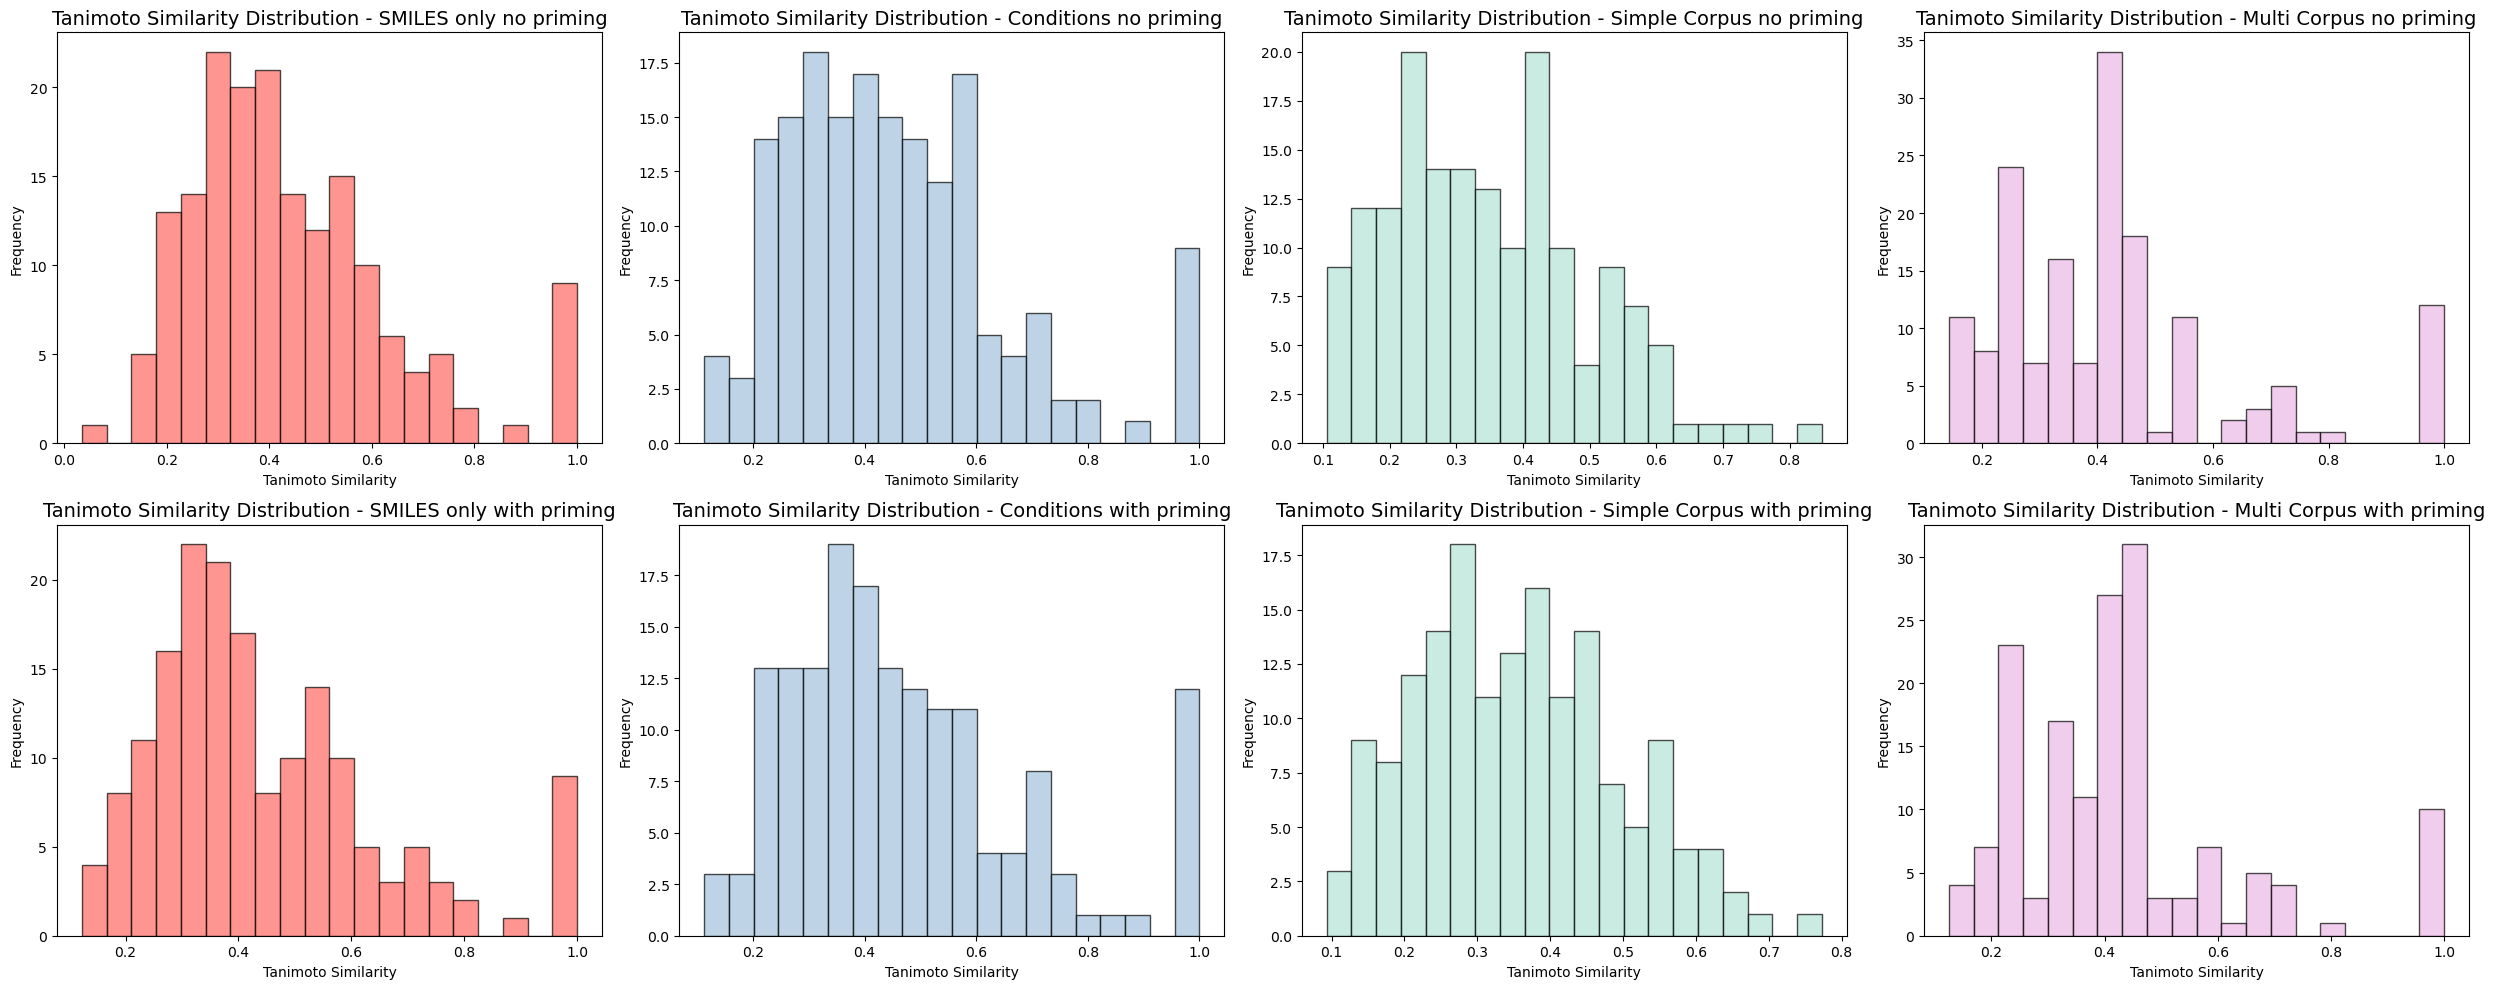

In [1048]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(2,4, figsize=(25,10))

axs[0,0].hist(df_smiles_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='#FF6961', edgecolor='black', alpha=0.7)
axs[0,0].set_title('Tanimoto Similarity Distribution - SMILES only no priming', fontsize=14)
axs[0,0].set_xlabel('Tanimoto Similarity')
axs[0,0].set_ylabel('Frequency')

axs[1,0].hist(df_smiles_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#FF6961', edgecolor='black', alpha=0.7)
axs[1,0].set_title('Tanimoto Similarity Distribution - SMILES only with priming', fontsize=14)
axs[1,0].set_xlabel('Tanimoto Similarity')
axs[1,0].set_ylabel('Frequency')

axs[0,1].hist(df_cond_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='#A3C1DA', edgecolor='black', alpha=0.7)
axs[0,1].set_title('Tanimoto Similarity Distribution - Conditions no priming', fontsize=14)
axs[0,1].set_xlabel('Tanimoto Similarity')
axs[0,1].set_ylabel('Frequency')

axs[1,1].hist(df_cond_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#A3C1DA', edgecolor='black', alpha=0.7)
axs[1,1].set_title('Tanimoto Similarity Distribution - Conditions with priming', fontsize=14)
axs[1,1].set_xlabel('Tanimoto Similarity')
axs[1,1].set_ylabel('Frequency')

axs[0,2].hist(df_corpus_simple_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='#B2E3D7', edgecolor='black', alpha=0.7)
axs[0,2].set_title('Tanimoto Similarity Distribution - Simple Corpus no priming', fontsize=14)
axs[0,2].set_xlabel('Tanimoto Similarity')
axs[0,2].set_ylabel('Frequency')

axs[1,2].hist(df_corpus_simple_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#B2E3D7', edgecolor='black', alpha=0.7)
axs[1,2].set_title('Tanimoto Similarity Distribution - Simple Corpus with priming', fontsize=14)
axs[1,2].set_xlabel('Tanimoto Similarity')
axs[1,2].set_ylabel('Frequency')

axs[0,3].hist(df_multi_corpus_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='#EAB8E4', edgecolor='black', alpha=0.7)
axs[0,3].set_title('Tanimoto Similarity Distribution - Multi Corpus no priming', fontsize=14)
axs[0,3].set_xlabel('Tanimoto Similarity')
axs[0,3].set_ylabel('Frequency')

axs[1,3].hist(df_multi_corpus_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#EAB8E4', edgecolor='black', alpha=0.7)
axs[1,3].set_title('Tanimoto Similarity Distribution - Multi Corpus with priming', fontsize=14)
axs[1,3].set_xlabel('Tanimoto Similarity')
axs[1,3].set_ylabel('Frequency')

plt.subplots_adjust(hspace = 20, wspace = -10**10)

plt.tight_layout()

plt.show()

## 4.0 Causality

In [1047]:
test_data_multi_corpus.columns

Index(['prompt', 'answer', 'qa_pair', 'SMILES_pred'], dtype='object')

In [1049]:
df_causal = test_data_multi_corpus['qa_pair']

In [1050]:
df_causal.reset_index(drop=True, inplace = True)

In [1051]:
df_causal.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/dataset_for_causal_generation', index=False)

In [1052]:
causal_interpretation_1 = "causal relationships for your DAG: Functional Group A influences the Reaction Rate and the Product formed in the reaction. Functional Group B also affects the Reaction Rate and the resulting Product. The Reaction Rate is further influenced by the Catalyst used in the reaction. Reactant A and Reactant B each contribute to the overall reaction conditions. Other factors such as Solvent, Temperature, and pH interact with the functional groups and reactants, impacting the reaction dynamics."

In [603]:
causal_interpretation_2 = """

Reactivity and Structure: The reactions mainly involve the condensation of aldehydes and ketones, often forming chalcone derivatives. The presence of functional groups, such as halogens or hydroxyl groups, influences the reactivity and product structure significantly.
Temperature and Time: Many reactions occur under specific temperature ranges (typically room temperature or slightly elevated temperatures) and require varying times for completion. Increased temperature often correlates with faster reaction rates.
Solvent Effects: The choice of solvent, such as ethanol or water, can affect solubility and reactivity, highlighting the importance of solvent polarity in organic reactions.
Catalysis: The use of bases (e.g., NaOH) is common, indicating that these reactions often proceed via a base-catalyzed mechanism, facilitating the nucleophilic attack on electrophilic carbonyl groups.
Product Complexity: The products often retain or enhance the aromatic character of the reactants, with substitution patterns being influenced by the electronic effects of substituents.

"""

In [899]:
causal_interpretation_3 = """
Temperature: Increases reaction rate and affects product selectivity (High influence).
Time: Controls the extent of the reaction, longer time ensures full conversion (High influence).
Catalyst: Drastically speeds up the reaction and can control selectivity (Very High influence).
Solvent: Stabilizes intermediates, impacts reaction pathway (Moderate influence).
Reactant Structure: Determines the reaction mechanism and final product (Very High influence).
Other Conditions: Inert atmosphere or stirring ensures controlled reactions but with moderate impact.
"""

In [898]:
causal_interpretation_4 = """
Temperature as a Causal Factor:
Temperature plays a critical role in determining the speed and outcome of chemical reactions. For example, in reactions conducted at higher temperatures (e.g., 25°C), the reactants generally have more kinetic energy, which increases the likelihood of effective collisions and leads to faster reaction rates. In contrast, reactions at lower temperatures (e.g., 0°C) may proceed more slowly, leading to different products or incomplete reactions.
In the dataset, a reaction at 25°C with no solvent (neat) produced a different product compared to a similar reaction conducted at 24.84°C in ethanol. This difference highlights the effect of small variations in temperature on the energy dynamics of reactant molecules, thereby altering the reaction pathway and product formation.
Time as a Causal Factor:
Reaction time is another important factor that influences product formation. Longer reaction times often allow for complete conversion of reactants into products, while shorter times may result in intermediate or partial products.
For instance, reactions with a 6-hour duration in ethanol yielded distinct products compared to reactions where the reaction time is unknown or much shorter (e.g., 1 hour in water). This indicates that longer durations allow more complete reactions or favor the formation of more complex products, as seen with extended reaction times in organic solvents like ethanol.
Solvent as a Causal Factor:
The choice of solvent directly influences the solubility of reactants, the rate of reaction, and the stability of intermediates. Polar solvents like ethanol or water stabilize charged intermediates and can accelerate reactions involving ionic species, while neat conditions (no solvent) reduce the stabilization of intermediates and may favor different reaction mechanisms.
A clear example from the dataset shows that a reaction conducted in ethanol at 24.84°C produced a different product compared to a reaction at 25°C conducted in water or neat conditions (no solvent). The polar solvent ethanol can stabilize charged intermediates, allowing the reaction to proceed through a different pathway than it would in water or without any solvent.
In water-based reactions, especially those involving aqueous NaOH, the solvent promotes reactions through base-catalyzed mechanisms, which can lead to products with different functional groups compared to reactions in organic solvents like ethanol.
Catalyst as a Causal Factor:
Catalysts accelerate reaction rates by lowering the activation energy required for the reaction to proceed. In many reactions where the catalyst is unknown, we may expect the reaction to proceed more slowly or require specific conditions (e.g., elevated temperature or longer reaction times) to reach completion.
The absence of a known catalyst in the dataset doesn't prevent reactions from occurring but suggests that the outcomes could be different if a catalyst had been used. For example, in reactions where a weak base like NaOH was added, the product formation could be influenced by the base, which catalyzes deprotonation steps, leading to different enolate intermediates compared to non-catalyzed reactions.
Reactants as a Causal Factor:
The structure and reactivity of the starting reactants have a direct influence on the product formed. Reactants with different functional groups (e.g., carbonyls, hydroxyls, and halogens) may undergo different transformations depending on the conditions.
For example, reactions involving O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O as the first reactant and COC1=CC=C(C=C1)C(C)=O as the second reactant under ethanol at 24.84°C yielded a specific product with a hydroxyl group. Changing the reactants (even under similar conditions) would lead to different reaction intermediates, and thus, different products.
Other Conditions (e.g., Inert Atmosphere, Sealed Tubes, etc.):
Inert atmospheres and sealed environments can prevent unwanted side reactions such as oxidation, which might otherwise alter the product. For instance, conducting a reaction in a sealed tube under neat conditions (no solvent) at 25°C led to a different aldol product compared to reactions performed in ethanol. The absence of solvent and restricted gas exchange alters the reaction environment, potentially influencing the product formed.
"""


In [1054]:
causal_interpretation_5 = """
Higher temperatures (e.g., 65°C or microwave-assisted at 150°C) favor Claisen-Schmidt condensations and reactions forming more stable conjugated products like chalcones.
Lower temperatures (e.g., 20-25°C) are often sufficient for aldol-type condensations, where selectivity and avoiding side reactions are key, and the activation energy is lower.
In the aldol and Claisen-Schmidt condensations, ethanol likely helps in solubilizing both the carbonyl compounds and the base, ensuring the enolate formation proceeds smoothly. It also serves as a stabilizing medium for charged intermediates or transition states.
Why Water or Mixed Solvents?: Water is often used in base-catalyzed aldol reactions because it is a polar protic solvent that can facilitate the dissolution of ionic species, especially the base (NaOH or KOH). Water promotes the generation of hydroxide ions (OH⁻), which are essential for deprotonating the α-hydrogen of carbonyl compounds to form enolate ions.
When water is mixed with ethanol, it allows for better control over solubility — ethanol can dissolve more organic substrates, while water improves the solubility of the base. Mixed solvents are often used to balance the solubility of both the organic substrates and the inorganic catalysts or bases.
In the aldol reactions conducted under neat conditions, high concentrations of reactants likely favor the rapid formation of enolate intermediates and enhance the nucleophilic addition step. In microwave-assisted reactions, the energy provided directly to the reactants in the absence of solvent can dramatically increase reaction rates and yields.
Strong bases like sodium hydroxide are more likely to initiate aldol condensations due to their ability to generate enolate ions.
Mild bases such as piperidine or diethylamine favor Knoevenagel condensations or Mannich reactions by catalyzing proton transfers without aggressively attacking the substrate.
Non-nucleophilic bases like triethylamine mainly serve to neutralize byproducts and promote condensation reactions without directly participating in the nucleophilic attack.
Acid catalysts are well-suited for reactions that involve protonation, dehydration, or carbocation formation, such as aldol and Friedel-Crafts reactions.
Base catalysts are key to reactions involving enolate formation or nucleophilic attacks, driving aldol and Knoevenagel condensations.
Metal catalysts are ideal for redox reactions or cyclizations, helping stabilize intermediates and promoting complex ring formations or reductions.
Nanocatalysts and green catalysts offer environmentally friendly options for C-C bond formation and efficient reactions under mild conditions, aligning with green chemistry principles.
Organocatalysts facilitate nucleophilic addition reactions, promoting asymmetric synthesis and mil
Reactions like aldol condensations generally take 4-12 hours, depending on the conditions, while cyclization reactions or reactions with specialized catalysts can finish within 2-6 hours.
Reaction time is heavily influenced by a combination of temperature, catalysts, solvent, and the specific reaction mechanism. Faster reactions are typically associated with higher temperatures, efficient catalysts, and polar solvents, while longer reaction times are more likely at lower temperatures or when using weaker catalysts.
"""


In [1055]:
causal_interpretation_5

'\nHigher temperatures (e.g., 65°C or microwave-assisted at 150°C) favor Claisen-Schmidt condensations and reactions forming more stable conjugated products like chalcones.\nLower temperatures (e.g., 20-25°C) are often sufficient for aldol-type condensations, where selectivity and avoiding side reactions are key, and the activation energy is lower.\nIn the aldol and Claisen-Schmidt condensations, ethanol likely helps in solubilizing both the carbonyl compounds and the base, ensuring the enolate formation proceeds smoothly. It also serves as a stabilizing medium for charged intermediates or transition states.\nWhy Water or Mixed Solvents?: Water is often used in base-catalyzed aldol reactions because it is a polar protic solvent that can facilitate the dissolution of ionic species, especially the base (NaOH or KOH). Water promotes the generation of hydroxide ions (OH⁻), which are essential for deprotonating the α-hydrogen of carbonyl compounds to form enolate ions.\nWhen water is mixed 

In [1695]:
def get_chatgpt_response_priming_causal(row, str_fs, str_causal):
    
    try:
        
        user_message = (
            f"Provide only the SMILES representation for the following question, without any explanation or extra text:\n\n"
            f"This is the few-shot training you can use:\n\n"
            f"{str_fs}\n\n"
            f"I also want you to understand the causal realtionship between variables:\n\n"
            f"{str_causal}\n\n"
            f"Now, for the new question:\n\n"
            f"Q: {row}\nA:"
        )
      
        response = client.chat.completions.create( 
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are an expert in organic chemistry specialized in aldol-type chemical reactions and you are also an expert in understanding causal relationships between variables"},
                {"role": "user", "content": user_message}
            ],
            max_tokens=100,  
            temperature=0.15 
        )
        
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"


### 4.1 Simple-corpus

In [1696]:
test_data_corpus_simple['SMILES_pred'] = ""

for index, row in test_data_corpus_simple.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt_corpus_training_5, causal_interpretation_4)
    
    test_data_corpus_simple.at[index, 'SMILES_pred'] = result

print(test_data_corpus_simple)

KeyboardInterrupt: 

In [1133]:
df_corpus_simple_tanim = df_prep_tanim(test_data_corpus_simple)

In [1134]:
df_corpus_simple_tanim

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1N(CC)CC
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC=CC=C1
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1C(=C\C(=O)C1=CC=CC=C1)N(=O)=O
...,...,...
213,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C(=O)OC(C)(C)C)C(=O)OC(=O)NO)C)C
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(C=C1)C(=O)C2=C(OC)C=C(C=C2)N(=O)=O
215,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(C)=O)C(O)=C(CC=C)C2=C1C(=O)C1=CC=CC=C...
216,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,CCOC(=O)C(F)(F)C(=O)C=CC1=CC=C(Cl)C=C1C(C)=O


In [1135]:
df_corpus_simple_tanim_filtered = filter_invalid_smiles(df_corpus_simple_tanim, 'SMILES_pred')
df_corpus_simple_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_corpus_simple_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[16:36:38] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(C)=O)C(=O)C1=C(C=O)C=C1'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'OC1=CC=C(C=C1)C(=O)C1=CC=CC=C1OCOC2=C1'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'O=C1CCCCC1C(=C(C=C1)N(=O)=O)C=O'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'COC1=CC=C(C=C1)C(=O)C1=CC=C(C(OC)=C1)C(OC)=C1'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=CC=C(Cl)C(=C)C1=C(CN(C)C)C(=O)C=C1'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'CC1=CC=C(C=C1)C(=O)C2=C(C=CC=C2)C=CC1=CC=C2O'
[16:36:38] SMILES Parse Error: unclosed ring for input: 'O=CC1=CC=C(S1)C(=O)C=CC=C1'
[16:36:38] SMILES Parse Error: syntax error while parsing: OC1=C(C=O)C=C(C=C1)C(Cl)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=
[16:36:38] SMILES Parse Error: Failed parsing SMILES 'OC1=C(C=O)C=C(C=C1)C(Cl)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C(=C)C

In [1136]:
df_corpus_simple_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1=CC=CC=C1N(CC)CC,0.277778
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=C1)C(=O)C1=CC=CC=C1,0.333333
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC1=CC=C(C=C1)C(=O)C=CC1=CC=CC=C1,0.514286
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,OC1=CC=C(C=C1)C(=O)C=C(C=CC1=CC=CC=C1)C=O,0.404255
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1C(=C\C(=O)C1=CC=CC=C1)N(=O)=O,0.357143
...,...,...,...
208,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)N(C1=CC=...,O=C(C1=CC=C(C=C1)N(C1=CC=CC=C1)C1=CC=CC=C1)C1=...,0.431818
209,O=C(C=CC1=CC(=CC=C1)N(=O)=O)C1=NC=CC=C1,CC(=O)C1=CC(=CC=C1)N(=O)=O,0.413043
212,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,FC(F)(F)C1=CC=C(C=C1)C(=O)C1=CC=C(C=C1)C(C)=O,0.404762
214,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(C=C1)C(=O)C2=C(OC)C=C(C=C2)N(=O)=O,0.287671


In [1137]:
print(tanim_avg(df_corpus_simple_tanim_filtered), tanim_count_perfpred(df_corpus_simple_tanim_filtered))

0.3564222758284231 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 4.2 Multi-corpus

In [1138]:
test_data_multi_corpus['SMILES_pred'] = ""

for index, row in test_data_multi_corpus.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt__multi_corpus_training_15, causal_interpretation_4)
    
    test_data_multi_corpus.at[index, 'SMILES_pred'] = result

print(test_data_multi_corpus)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/302998704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_multi_corpus['SMILES_pred'] = ""


                                                prompt  \
0    Predict the product for the following reaction...   
1    Predict the product for the following reaction...   
2    Predict the product for the following reaction...   
3    Predict the product for the following reaction...   
5    Predict the product for the following reaction...   
..                                                 ...   
633  Predict the product for the following reaction...   
634  Predict the product for the following reaction...   
636  Predict the product for the following reaction...   
637  Predict the product for the following reaction...   
641  Predict the product for the following reaction...   

                                                answer  \
0    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
1    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
2    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
3    OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...   
5    COC1=CC=

In [1139]:
df_multi_corpus_tanim = df_prep_tanim(test_data_multi_corpus)

In [1140]:
df_multi_corpus_tanim


,SMILES_true,SMILES_pred
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(C=C1)C(=O)N(C2=CC=CC=C2)C2=CC=CC=C...
1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(Cl)C=C1)C1=CC2=C(C(=O)N(C)C2)C=C1
2,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(C=C1)C(=O)N(C2=CC=CC=C2)C2=CC=C(C=...
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C=C\C1=CC=C(Cl)C=C1)C1=CC=CC=C2C2=CC=CC=N1
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C(C=C\C1=CC=C(C=C1)C(=O)N(CC2=CC=CC=C2)C2=CC...
...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,OC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC2=C(OCO2)C=C1
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1


In [1141]:
df_multi_corpus_tanim_filtered = filter_invalid_smiles(df_multi_corpus_tanim, 'SMILES_pred')
df_multi_corpus_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_multi_corpus_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[16:40:37] SMILES Parse Error: ring closure 2 duplicates bond between atom 16 and atom 17 for input: 'O=C(C=C\C1=CC=C(Cl)C=C1)C1=CC=CC=C2C2=CC=CC=N1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'O=C(C=C\C1=CC=C(C=C1)C(=O)N(CC2=CC=CC=C2)C2=CC=C1)C1=CC=CC=C1'
[16:40:37] Explicit valence for atom # 12 C, 5, is greater than permitted
[16:40:37] SMILES Parse Error: unclosed ring for input: 'OC1=C(C=O)C=CC=C1C(=O)C1=CC=C(C=C1)C=C1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=O)=CC=C1O\C(=O)C(C)C1=CC=C(C=C1)C=C1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=O)=CC=C1C(=O)C(C)=C1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'CN(C)C1=CC=C(C=C1)C(=O)C1=CC=C(C=C1)C=C1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'CN(C)C1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)C(=O)C1=CC=C(C=C1)C=C2'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'CN(C)C1=CC=C(C=C1)C(=O)C=C1'
[16:40:37] SMILES Parse Error: unclosed ring for input: 'CN(C)

In [1142]:
df_multi_corpus_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(C=C1)C(=O)N(C2=CC=CC=C2)C2=CC=CC=C...,0.296296
1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(Cl)C=C1)C1=CC2=C(C(=O)N(C)C2)C=C1,0.262295
2,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(C=C1)C(=O)N(C2=CC=CC=C2)C2=CC=C(C=...,0.258065
5,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C(C=C\C1=CC=C(C=C1)C(=O)C2=CC=CC=C2)C1=CC2=C...,0.208333
6,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,0.372093
...,...,...,...
213,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,OC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC2=C(OCO2)C=C1,0.869565
214,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
215,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000
216,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,1.000000


In [1143]:
print(tanim_avg(df_multi_corpus_tanim_filtered), tanim_count_perfpred(df_multi_corpus_tanim_filtered))

0.43211271898821124 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 11


### 4.3 Conditions with priming

In [1144]:
test_data_cond['SMILES_pred'] = ""

for index, row in test_data_cond.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt_cond_training_5, causal_interpretation_4)
    
    test_data_cond.at[index, 'SMILES_pred'] = result

print(test_data_cond)

                                                  prompt  \
537    Predict the product for the following reaction...   
1494   Predict the product for the following reaction...   
2728   Predict the product for the following reaction...   
3206   Predict the product for the following reaction...   
3478   Predict the product for the following reaction...   
...                                                  ...   
31663  Predict the product for the following reaction...   
31719  Predict the product for the following reaction...   
31732  Predict the product for the following reaction...   
31740  Predict the product for the following reaction...   
31793  Predict the product for the following reaction...   

                                                  answer  \
537    CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...   
1494             COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1   
2728                 OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1   
3206               COC1=CC=C(C=C1)C(=O)

In [1145]:
df_cond_tanim = df_prep_tanim(test_data_cond)

In [1146]:
df_cond_tanim

,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1\C=C\C1=CC=CC=C1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CCC2=C1C=CC=C2
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=CC=C1C(=O)H
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O
...,...,...
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)NO
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...
216,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,COC1=C(C(C)=O)C(O)=C(CC=C)C2=C1C=CO2\C=C\C1=CC...


In [1147]:
df_cond_tanim_filtered = filter_invalid_smiles(df_cond_tanim, 'SMILES_pred')
df_cond_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[16:47:24] SMILES Parse Error: syntax error while parsing: CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=CC=C1C(=O)H
[16:47:24] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC=CC=C1C(=O)H'
[16:47:24] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:47:24] Explicit valence for atom # 7 N, 4, is greater than permitted
[16:47:24] SMILES Parse Error: syntax error while parsing: COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H
[16:47:24] SMILES Parse Error: Failed parsing SMILES 'COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'COC1=CC(OC)=C(C(C)=O)C(O)=C1\C=C\C1=CC=CC=C1C(=O)H'
[16:47:24] SMILES Parse Error: syntax error while parsing: CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H
[16:47:24] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H' for input: 'CC(=O)C1=CC=C2OCOC2=C1\C=C\C1=CC=CC=C1C(=O)H'
[16:47:24] SMILES Parse Error: unclosed ring for input: 

In [1148]:
df_cond_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1\C=C\C1=CC=CC=C1,0.200000
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=O)C=C1\C=C\C1=CCC2=C1C=CC=C2,0.362069
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=C1,0.800000
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1\C=C\C1=CC(=CC=C1)N(=O)=O,0.551020
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CC(C=O)=C1OC,0.520833
...,...,...,...
209,COC(=O)C(CO)C(O)(CCO[Si](C)(C)C(C)(C)C)\C=C\C,COC(=O)CC(O)C\C=C\C(=O)CCO[Si](C)(C)C(C)(C)C,0.362069
213,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(F)(F)F,COC1=CC=C(C=C1)C(=O)\C=C\C1=CC=C(C=C1)C(F)(F)F,1.000000
214,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,CC(C(C)=O)C(=O)OC(C)(C)C\C(=O)OC(=O)NO,0.183673
215,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,CC(=O)C1=CC=C(OCCN2C(C)=NC=C2N(=O)=O)C=C1\C=C\...,0.613333


In [1149]:
print(tanim_avg(df_cond_tanim_filtered), tanim_count_perfpred(df_cond_tanim_filtered))

0.4400839153064949 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 9


### 4.4 Tanimoto distributions

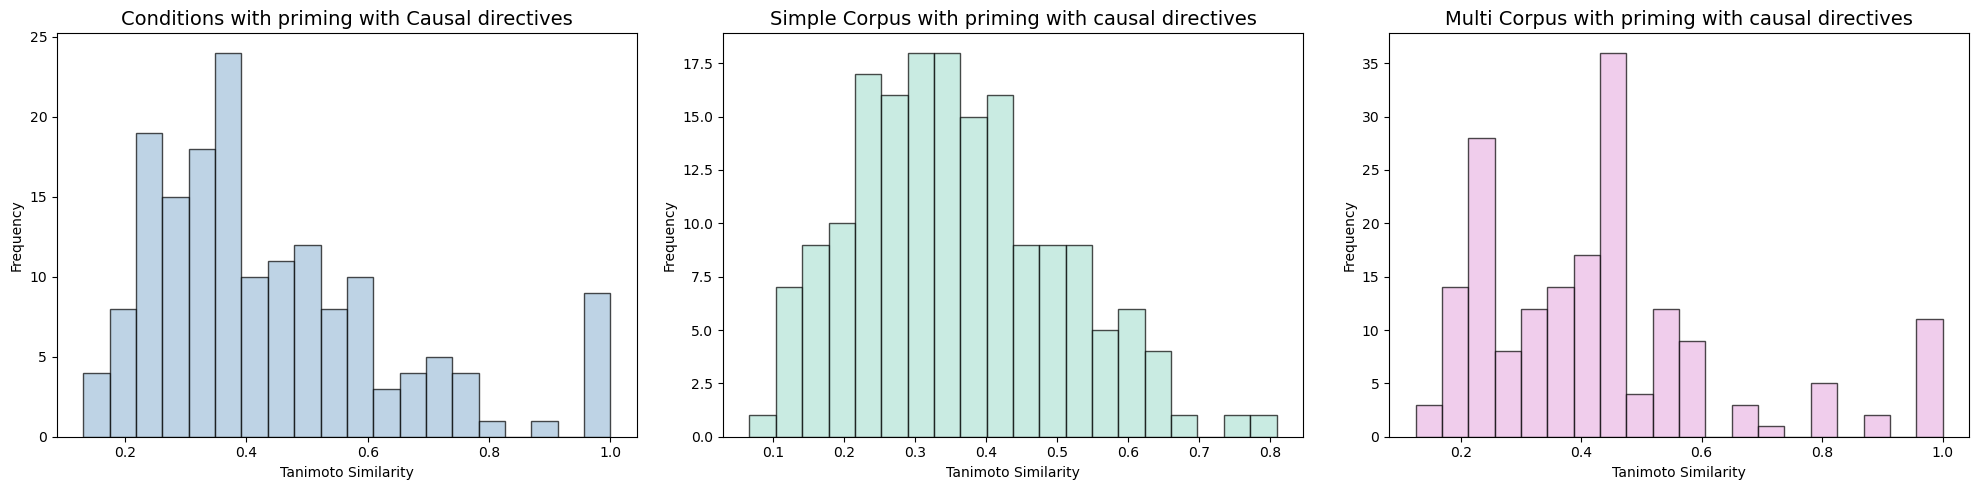

In [1150]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].hist(df_cond_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#A3C1DA', edgecolor='black', alpha=0.7)
axs[0].set_title('Conditions with priming with Causal directives', fontsize=14)
axs[0].set_xlabel('Tanimoto Similarity')
axs[0].set_ylabel('Frequency')


axs[1].hist(df_corpus_simple_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#B2E3D7', edgecolor='black', alpha=0.7)
axs[1].set_title('Simple Corpus with priming with causal directives', fontsize=14)
axs[1].set_xlabel('Tanimoto Similarity')
axs[1].set_ylabel('Frequency')

axs[2].hist(df_multi_corpus_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='#EAB8E4', edgecolor='black', alpha=0.7)
axs[2].set_title('Multi Corpus with priming with causal directives', fontsize=14)
axs[2].set_xlabel('Tanimoto Similarity')
axs[2].set_ylabel('Frequency')

plt.subplots_adjust(hspace = 20, wspace = -10**10)

plt.tight_layout()

plt.show()

### 5.0 Causal reasoning in GPT-4o prompt

1. generate a serie of question-answer to stimulate causal reasoning
2. once it is set up, test 50 questions and retrieve prediction ability 
3. Make a benchmark of predictions before this 


In [1455]:
df_causal_reason_multi = test_data_multi_corpus
df_causal_reason_simple = test_data_corpus_simple
df_causal_reason_cond = test_data_cond

In [1456]:
test_data_corpus_simple

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,Predict the product for the following reaction...
1,Predict the product for the following reaction...,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,Predict the product for the following reaction...
2,Predict the product for the following reaction...,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,Predict the product for the following reaction...
3,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,Predict the product for the following reaction...
4,Predict the product for the following reaction...,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,Predict the product for the following reaction...
...,...,...,...
213,Predict the product for the following reaction...,CC(=O)C(C)(N(O)C(=O)OC(C)(C)C)C(=O)OC(C)(C)C,Predict the product for the following reaction...
214,Predict the product for the following reaction...,COC1=CC=C(OC)C(C=CC(=O)C2=CC=C(OCCN3C(C)=NC=C3...,Predict the product for the following reaction...
215,Predict the product for the following reaction...,COC1=C(C=CC(=O)C2=C(OC)C3=C(OC=C3)C(CC=C)=C2O)...,Predict the product for the following reaction...
216,Predict the product for the following reaction...,CCOC(=O)C(F)(F)C(O)(CC(C)=O)C=CC1=CC=C(Cl)C=C1...,Predict the product for the following reaction...


In [1425]:
test_data_multi_corpus

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
1,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
2,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
3,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
5,Predict the product for the following reaction...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
...,...,...,...
633,Predict the product for the following reaction...,COC1=CC(=CC(OC)=C1OC)C(=O)\C=C\C1=CC=C2OCOC2=C1,Predict the product for the following reaction...
634,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...
636,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...
637,Predict the product for the following reaction...,O=C(\C=C\C1=CC2=C(OCO2)C=C1)C1=CC=CC=C1,Predict the product for the following reaction...


In [1457]:
df_causal_reason_multi.reset_index(drop=True, inplace=True)
df_causal_reason_simple.reset_index(drop=True, inplace=True)
df_causal_reason_cond.reset_index(drop=True, inplace=True)

In [1597]:
df_causal_reason_multi = df_causal_reason_multi.head(20)
df_causal_reason_simple = df_causal_reason_simple.head(20)
df_causal_reason_cond = df_causal_reason_cond.head(20)

In [1598]:
df_causal_reason_multi['prompt'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/causal_reason_multi_dataset50', index=False)
df_causal_reason_simple['prompt'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/causal_reason_simple_dataset50', index=False)
df_causal_reason_cond['prompt'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/causal_reason_cond_dataset50', index=False)

In [1431]:
df_causal_reason_multi_qa = test_data_multi_corpus['qa_pair'].tail(5)
df_causal_reason_simple_qa = test_data_corpus_simple['qa_pair'].tail(5)
df_causal_reason_cond_qa = test_data_cond['qa_pair'].tail(5)

In [1432]:
df_causal_reason_multi_qa.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/qa_causal_reason_multi_dataset50', index=False)
df_causal_reason_simple_qa.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/qa_causal_reason_simple_dataset50', index=False)
df_causal_reason_cond_qa.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/qa_causal_reason_cond_dataset50', index=False)

In [1451]:
def generate_few_shot_examples_causal(df):

    few_shot_examples = "\n\n".join(df)
    
    return few_shot_examples

### 5.1 Conditions dataset

In [1480]:
prompt_cond_causal_training_5 = generate_few_shot_examples_causal(df_causal_reason_cond_qa)

In [1494]:
df_causal_reason_cond['SMILES_pred'] = ""

for index, row in df_causal_reason_cond.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt_cond_causal_training_5, "")
    
    df_causal_reason_cond.at[index, 'SMILES_pred'] = result

print(df_causal_reason_cond)


/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/2956965224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_causal_reason_cond['SMILES_pred'] = ""


                                               prompt  \
0   Predict the product for the following reaction...   
1   Predict the product for the following reaction...   
2   Predict the product for the following reaction...   
3   Predict the product for the following reaction...   
4   Predict the product for the following reaction...   
5   Predict the product for the following reaction...   
6   Predict the product for the following reaction...   
7   Predict the product for the following reaction...   
8   Predict the product for the following reaction...   
9   Predict the product for the following reaction...   
10  Predict the product for the following reaction...   
11  Predict the product for the following reaction...   
12  Predict the product for the following reaction...   
13  Predict the product for the following reaction...   
14  Predict the product for the following reaction...   
15  Predict the product for the following reaction...   
16  Predict the product for the

In [1495]:
df_cond_tanim = df_prep_tanim(df_causal_reason_cond)
df_cond_tanim


,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1CCCCC1
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=CC2=C1C=CC=C2)=C1
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(C=CC(=O)C2=CC=C(C=C2)C=C1)C=C1C=CC=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(C=CC=C2C=CC=CC=C2)=C1C(=O)C=C...
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,COC1=CC=C(C(=O)C2=C(O)C=CC=C2)C(=CC(=O)N(=O)=O...
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,COC1=CC=C(C=C1)C(Cl)C(=O)C=CC1=CC=C(C=C1)C(=O)OC
6,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,CCOC(=O)C=[N]#NCC1=CC=C(C=C1)C(=O)C(F)(F)F
7,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,CCOC(=O)C=[N]#N\C1=CC=C(C=O)C=C1
8,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1,COC1=CC(C=CC(=O)C2=CC=C(C=C2)C(O)=C1)C(OC)=C1
9,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,CC(=O)C1=CC=C(C=CC(=O)C2=CC=CS2)C(O)=C1


In [1496]:
df_cond_tanim_filtered = filter_invalid_smiles(df_cond_tanim, 'SMILES_pred')
df_cond_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)



[14:59:22] SMILES Parse Error: unclosed ring for input: 'COC1=C(OC)C=C(C=CC2=C1C=CC=C2)=C1'
[14:59:22] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:59:22] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:59:22] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=CC(=O)C2=CC=C(C=C2)C(O)=C1)C(OC)=C1'
[14:59:22] SMILES Parse Error: unclosed ring for input: 'COC1=CC=C(C=C1)C(C=CC(=O)C2=C(O)C=CC=C2)=C1'
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WARNING: please use MorganGenerator
[14:59:22] DEPRECATION WA

In [1497]:
df_cond_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C1CCCCC1,0.122449
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(C=CC(=O)C2=CC=C(C=C2)C=C1)C=C1C=CC=C1,0.153846
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(C=CC=C2C=CC=CC=C2)=C1C(=O)C=C...,0.333333
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,COC1=CC=C(C(=O)C2=C(O)C=CC=C2)C(=CC(=O)N(=O)=O...,0.301587
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,COC1=CC=C(C=C1)C(Cl)C(=O)C=CC1=CC=C(C=C1)C(=O)OC,0.363636
9,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,CC(=O)C1=CC=C(C=CC(=O)C2=CC=CS2)C(O)=C1,0.392157
10,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(Cl)C=C1,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=O)C(Cl)C=C1,0.470588
11,CC(C)\C=C\CC(O)=O,CC(C)C(C(=O)O)C(=O)O,0.280000
12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=N1,CC(=O)C1=CC=C(Cl)C=C1C(=C)C1=CC=CC=N1,0.340000
13,OC1=CC=CC=C1C(=O)\C=C\C1=C(O)C=CC=C1,OC1=C(C=CC(=O)C2=C(C=O)C=CC=C2)C(=O)C=C1,0.452381


In [1498]:
print(tanim_avg(df_cond_tanim_filtered), tanim_count_perfpred(df_cond_tanim_filtered))

0.31915028485503844 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.2 Simple corpus dataset

In [1599]:
prompt_simple_causal_training_5 = generate_few_shot_examples_causal(df_causal_reason_simple_qa)

In [1468]:

df_causal_reason_simple['SMILES_pred'] = ""

for index, row in df_causal_reason_simple.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt_cond_causal_training_5, "")
    
    df_causal_reason_simple.at[index, 'SMILES_pred'] = result

print(df_causal_reason_simple)



/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/183687642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_causal_reason_simple['SMILES_pred'] = ""


                                               prompt  \
0   Predict the product for the following reaction...   
1   Predict the product for the following reaction...   
2   Predict the product for the following reaction...   
3   Predict the product for the following reaction...   
4   Predict the product for the following reaction...   
5   Predict the product for the following reaction...   
6   Predict the product for the following reaction...   
7   Predict the product for the following reaction...   
8   Predict the product for the following reaction...   
9   Predict the product for the following reaction...   
10  Predict the product for the following reaction...   
11  Predict the product for the following reaction...   
12  Predict the product for the following reaction...   
13  Predict the product for the following reaction...   
14  Predict the product for the following reaction...   
15  Predict the product for the following reaction...   
16  Predict the product for the

In [1469]:
df_simple_tanim = df_prep_tanim(df_causal_reason_simple)
df_simple_tanim



,SMILES_true,SMILES_pred
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C2=CC=CC=C2
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=CC2=C(C=O)C=CC=C2)C=C1
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC(=O)C=C1C1=CC=CC=C1
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(C=CC=CC=O)C=CC1=CC=C(C=C1)C=O
4,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,CC(=O)C1=C(O)C=CC=C1C(=CC(=O)N(=O)=O)C=C1
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,COC1=CC(Cl)=CC(=C1)C(=O)C=C(C)C(=O)C1=CC=C(C=C...
6,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,CCOC(=O)C(C=CC1=CC=C(C=O)C=C1)C(F)(F)F
7,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,CCOC(=O)C=C(C1=CC=C(C=O)C=C1)C=[N]#N
8,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1,COC1=CC(C=CC(=O)C2=CC=C(C=C2)C(O)=C1)C(OC)=C1
9,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,CC(=O)C1=CC=CC(=C(C=CC=O)C2=CC=CS2)C=C1


In [1470]:
df_simple_tanim_filtered = filter_invalid_smiles(df_simple_tanim, 'SMILES_pred')
df_simple_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_simple_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)




[14:19:06] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=C(O)C=CC=C1C(=CC(=O)N(=O)=O)C=C1'
[14:19:06] SMILES Parse Error: unclosed ring for input: 'COC1=CC(C=CC(=O)C2=CC=C(C=C2)C(O)=C1)C(OC)=C1'
[14:19:06] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=C(C=CC=C1)C(=C)C=CC=C1C(=O)OC1=C(C=O)C=CC=C1'
[14:19:06] SMILES Parse Error: unclosed ring for input: 'COC1=CC=C(C=C1)C(=O)C(C=CC(=O)C2=C(O)C=CC=C2)=C1'
[14:19:06] SMILES Parse Error: unclosed ring for input: 'O=C1CCCCC1C(=C(C=C1)N(=O)=O)C'
[14:19:06] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=CC=C(OCC#C)C(C=CC(=O)C2=CC=C(C=C2)C=C1)C=C1'
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION WARNING: please use MorganGenerator
[14:19:06] DEPRECATION W

In [1471]:
df_simple_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,O=C1CCCCC1C(=O)C2=CC=CC=C2,0.160000
1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,COC1=C(OC)C=C(C=CC2=C(C=O)C=CC=C2)C=C1,0.416667
2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,CC(=O)C1=C(O)C=CC(=O)C=C1C1=CC=CC=C1,0.244444
3,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1,COC1=CC=C(C=C1)C(C=CC=CC=O)C=CC1=CC=C(C=C1)C=O,0.326923
5,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,COC1=CC(Cl)=CC(=C1)C(=O)C=C(C)C(=O)C1=CC=C(C=C...,0.344828
6,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,CCOC(=O)C(C=CC1=CC=C(C=O)C=C1)C(F)(F)F,0.303571
7,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,CCOC(=O)C=C(C1=CC=C(C=O)C=C1)C=[N]#N,0.285714
9,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,CC(=O)C1=CC=CC(=C(C=CC=O)C2=CC=CS2)C=C1,0.229508
10,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(Cl)C=C1,ClC1=CC=C(C=C1)C(=O)C=CC1=CC=C(C=C1)C(C)=O,0.694444
11,CC(C)\C=C\CC(O)=O,CC(C)C(=O)C(=O)CC(=O)O,0.321429


In [1472]:

print(tanim_avg(df_simple_tanim_filtered), tanim_count_perfpred(df_simple_tanim_filtered))

0.3333846561099754 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.3 Multi-corpus dataset

In [1538]:
prompt_multi_causal_training_5 = generate_few_shot_examples_causal(df_causal_reason_multi_qa)

In [ ]:
df_causal_reason_multi['SMILES_pred'] = ""

for index, row in df_causal_reason_multi.iterrows():

    result = get_chatgpt_response_priming_causal(row['prompt'], prompt_multi_causal_training_5, "")
    
    df_causal_reason_multi.at[index, 'SMILES_pred'] = result

print(df_causal_reason_multi)


In [ ]:
df_multi_tanim = df_prep_tanim(df_causal_reason_multi)
df_multi_tanim

,SMILES_true,SMILES_pred
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=C(C(=O)C2=CC=CC=C2Cl)C=C1)N(C2=CC=CC...
1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C(C1=CC=CC=C1)N(C2=CC=CC=C2)C1=O
2,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=C...
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=C...
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C(=O)C1)C=C2
5,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.COC1=CC=C(C...
6,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O=C(\C=C\C1=CC=C(C(C)N(C)C)C=C1)C1CCCC1
7,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=O)C=C1C(=O)C1CCCC1
8,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C(\C=C\C1=CC=CC=C1)C(=O)N1[C@H](CC2=CC=CC=C2...
9,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C\C=C\C1=CC=CC=C1C(=O)N1[C@H](CC2=CC=CC=C2)C...


In [ ]:
df_multi_tanim_filtered = filter_invalid_smiles(df_multi_tanim, 'SMILES_pred')
df_multi_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_multi_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[14:28:40] SMILES Parse Error: unclosed ring for input: 'O=C(C1=CC=C(C(=O)C2=CC=CC=C2Cl)C=C1)N(C2=CC=CC=C2)C1=O'
[14:28:40] SMILES Parse Error: unclosed ring for input: 'O=C(C1=CC=CC=C1)N(C2=CC=CC=C2)C1=O'
[14:28:40] SMILES Parse Error: unclosed ring for input: 'O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=CC=C1'
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: please use MorganGenerator
[14:28:40] DEPRECATION WARNING: plea

In [ ]:
df_multi_tanim_filtered

,SMILES_true,SMILES_pred,tanimoto_similarity
3,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(Cl)C=C1C(=O)C1=CC=C...,0.274194
4,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=C(C(=O)C1)C=C2,0.266667
5,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.COC1=CC=C(C...,0.508475
6,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O=C(\C=C\C1=CC=C(C(C)N(C)C)C=C1)C1CCCC1,0.181818
7,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,CCN(CC)C1=CC=C(C=O)C=C1C(=O)C1CCCC1,0.288462
8,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C(\C=C\C1=CC=CC=C1)C(=O)N1[C@H](CC2=CC=CC=C2...,0.566667
9,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C\C=C\C1=CC=CC=C1C(=O)N1[C@H](CC2=CC=CC=C2)C...,0.476923
10,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C(C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)COC1=O,0.586207
11,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,O=C(C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)COC1=O,0.586207
12,CC(=O)C=CC1=CC=CO1,O=C(\C(C)=C\C1=CC=CO1)C(C)=O,0.529412


In [ ]:
print(tanim_avg(df_multi_tanim_filtered), tanim_count_perfpred(df_multi_tanim_filtered))

0.41835380174182696 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.4 Conditions with causality

In [1689]:
df_pred_causal_cond = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/results_pred_cond.xlsx', engine='openpyxl')

In [1690]:
df_pred_causal_cond['SMILES_true'] = df_cond_tanim['SMILES_true'].head(20)

In [1691]:
df_pred_causal_cond

,SMILES_pred,SMILES_true
0,O=CC1=CCCCC1,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...
1,COC1=C(OC)C=C(C=CC=C1)C=C1,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1
2,CC(=O)C1=C(O)C=CC(C=O)=C1,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1
3,COC1=C(C(C=O)C2=CC=CC=CC=C2)=C1,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1
4,CC(=O)C1=C(OCC(=O)N(=O)=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O
5,CC(=O)C1=CC=C(Cl)C=C1C(C)=O,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1
6,CCOC(=O)C=[N]#N,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F
7,CCOC(=O)C=[N]#N,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1
8,COC1=CC(OC)=C(C(C)=O)C(O)=C1,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1
9,O=CC1=CC=C(C(C)=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1


In [1692]:
df_pred_causal_cond_filtered = filter_invalid_smiles(df_pred_causal_cond, 'SMILES_pred')
df_pred_causal_cond_filtered.loc[:, 'tanimoto_similarity'] = df_pred_causal_cond_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[19:24:43] SMILES Parse Error: unclosed ring for input: 'COC1=C(OC)C=C(C=CC=C1)C=C1'
[19:24:43] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:24:43] SMILES Parse Error: unclosed ring for input: 'COC1=CC=C(C=C1)C(C=O)C(Cl)C=CC=C1'
[19:24:43] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=C(OCC(C=O)C1)C=C1'
[19:24:43] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=C(OCC(=O)C2=C1)C=C1'
[19:24:43] SMILES Parse Error: unclosed ring for input: 'CC(=O)C1=C(OCC(C=O)C2=C1)C=C1'
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECATION WARNING: please use MorganGenerator
[19:24:43] DEPRECA

In [1693]:
df_pred_causal_cond_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,O=CC1=CCCCC1,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,0.162791
2,CC(=O)C1=C(O)C=CC(C=O)=C1,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,0.307692
4,CC(=O)C1=C(OCC(=O)N(=O)=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,0.155172
5,CC(=O)C1=CC=C(Cl)C=C1C(C)=O,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,0.266667
6,CCOC(=O)C=[N]#N,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,0.282609
7,CCOC(=O)C=[N]#N,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,0.302326
8,COC1=CC(OC)=C(C(C)=O)C(O)=C1,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1,0.523810
9,O=CC1=CC=C(C(C)=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,0.120000
11,OC(=O)C(C)C=O,CC(C)\C=C\CC(O)=O,0.307692
12,O=CC1=CC=C(Cl)C=C1,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CC=CC=N1,0.270270


In [1694]:
print(tanim_avg(df_pred_causal_cond_filtered), tanim_count_perfpred(df_pred_causal_cond_filtered))

0.2977579406802103 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.5 Simple corpus with causality


In [1631]:
df_pred_causal_simple = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/results_pred_simple.xlsx', engine='openpyxl')


In [1632]:
df_pred_causal_simple['SMILES_true'] = df_simple_tanim['SMILES_true'].head(20)
df_pred_causal_simple


,SMILES_pred,SMILES_true
0,C1=CC=CC=CC1C(C=O)=O,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...
1,COC1=CC=C(C=C1)C(C=O)C2=CC=CC=C2,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1
2,CC(=O)C1=CC=CC=C1C2=CC=CC=C2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1
3,O=C(C=CC1=CC=CC=C1)C(C)=C1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1
4,CC(=O)C1=CC=CC=C1C=C1C=CC(=CC=N(O)=O)C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O
5,CC(=O)C1=CC=C(Cl)C=C1C=C1C=CC(=O)OC1,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1
6,CCOC(=O)C=C1C=CC(F)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F
7,CCOC(=O)C=C1C=CC(Br)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1
8,COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1
9,O=CC1=CC=CS1C=C1C=CC(O)=C(C=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1


In [1633]:
df_pred_causal_simple_filtered = filter_invalid_smiles(df_pred_causal_simple, 'SMILES_pred')
df_pred_causal_simple_filtered.loc[:, 'tanimoto_similarity'] = df_pred_causal_simple_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[21:55:10] Explicit valence for atom # 12 C, 5, is greater than permitted
[21:55:10] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2'
[21:55:10] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2'
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATI

In [1634]:
df_pred_causal_simple_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,C1=CC=CC=CC1C(C=O)=O,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,0.065217
1,COC1=CC=C(C=C1)C(C=O)C2=CC=CC=C2,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,0.211538
2,CC(=O)C1=CC=CC=C1C2=CC=CC=C2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,0.297297
4,CC(=O)C1=CC=CC=C1C=C1C=CC(=CC=N(O)=O)C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,0.225806
5,CC(=O)C1=CC=C(Cl)C=C1C=C1C=CC(=O)OC1,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,0.209677
6,CCOC(=O)C=C1C=CC(F)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,0.232143
7,CCOC(=O)C=C1C=CC(Br)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,0.264151
9,O=CC1=CC=CS1C=C1C=CC(O)=C(C=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,0.096774
10,ClC1=CC=C(C=O)C=C1C=C1C=CC(OC)=CC1,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(Cl)C=C1,0.224138
11,CC(C)CCC(C(C)CC=O)=O,CC(C)\C=C\CC(O)=O,0.235294


In [1635]:

print(tanim_avg(df_pred_causal_simple_filtered), tanim_count_perfpred(df_pred_causal_simple_filtered))

0.22475216480809823 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.6 Multi corpus causality

In [1660]:
df_pred_causal_multi = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/results_pred_multi.xlsx', engine='openpyxl')


In [1661]:
df_pred_causal_multi['SMILES_true'] = df_multi_tanim['SMILES_true'].head(20)
df_pred_causal_multi

,SMILES_pred,SMILES_true
0,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...
1,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...
2,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...
3,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...
4,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...
5,O=C(C=C)C1=CC=C(C2=CC=CC=C2)C=C1C(=O)N1,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...
6,CCN(CC)C1=CC=C(C=O)C=C1.C1CCCC1=O,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
7,CCN(CC)C1=CC=C(C=O)C=C1.C1CCCC1=O,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
8,O=C\C=C\C1=CC=CC=C1.C=CCCC(=O)N1[C@H](CC2=CC=C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
9,O=C\C=C\C1=CC=CC=C1.C=CCCC(=O)N1[C@H](CC2=CC=C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...


In [1662]:

df_pred_causal_multi_filtered = filter_invalid_smiles(df_pred_causal_multi, 'SMILES_pred')
df_pred_causal_multi_filtered.loc[:, 'tanimoto_similarity'] = df_pred_causal_multi_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[22:48:57] SMILES Parse Error: unclosed ring for input: 'O=C(C=C)C1=CC=C(C2=CC=CC=C2)C=C1C(=O)N1'
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPRECATION WARNING: please use MorganGenerator
[22:48:57] DEPREC

In [1663]:
df_pred_causal_multi_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,0.464286
1,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,0.464286
2,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,0.464286
3,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,0.464286
4,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O.CC(=O)C1=CC...,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,0.365079
6,CCN(CC)C1=CC=C(C=O)C=C1.C1CCCC1=O,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.567568
7,CCN(CC)C1=CC=C(C=O)C=C1.C1CCCC1=O,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.567568
8,O=C\C=C\C1=CC=CC=C1.C=CCCC(=O)N1[C@H](CC2=CC=C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.560606
9,O=C\C=C\C1=CC=CC=C1.C=CCCC(=O)N1[C@H](CC2=CC=C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.560606
10,O=C\C=C\C1=CC=CC=C1.C=CCCC(=O)N1[C@H](CC2=CC=C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.560606


In [1664]:

print(tanim_avg(df_pred_causal_multi_filtered), tanim_count_perfpred(df_pred_causal_multi_filtered))

0.5473569263042947 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


### 5.4 Chemical reaction vizualization 

In [ ]:
df_cond_comparaison = df_cond_filtered[['reactant_1', 'reactant_2', 'product']]

In [ ]:
df_pred_causal_simple = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/dataset_test_set_200/results_pred_simple.xlsx', engine='openpyxl')


In [ ]:
df_pred_causal_simple['SMILES_true'] = df_simple_tanim['SMILES_true'].head(20)
df_pred_causal_simple


,SMILES_pred,SMILES_true
0,C1=CC=CC=CC1C(C=O)=O,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...
1,COC1=CC=C(C=C1)C(C=O)C2=CC=CC=C2,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1
2,CC(=O)C1=CC=CC=C1C2=CC=CC=C2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1
3,O=C(C=CC1=CC=CC=C1)C(C)=C1=CC=CC=C1,COC1=CC=C(C=C1)C(=O)C=CC=CC1=CC=CC=C1
4,CC(=O)C1=CC=CC=C1C=C1C=CC(=CC=N(O)=O)C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O
5,CC(=O)C1=CC=C(Cl)C=C1C=C1C=CC(=O)OC1,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1
6,CCOC(=O)C=C1C=CC(F)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F
7,CCOC(=O)C=C1C=CC(Br)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1
8,COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2,COC1=CC(OC)=C(C(=O)\C=C\C2=CC=C(C)C=C2)C(O)=C1
9,O=CC1=CC=CS1C=C1C=CC(O)=C(C=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1


In [ ]:
df_pred_causal_simple_filtered = filter_invalid_smiles(df_pred_causal_simple, 'SMILES_pred')
df_pred_causal_simple_filtered.loc[:, 'tanimoto_similarity'] = df_pred_causal_simple_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[21:55:10] Explicit valence for atom # 12 C, 5, is greater than permitted
[21:55:10] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2'
[21:55:10] SMILES Parse Error: unclosed ring for input: 'COC1=CC(OC)=C(C(C)=O)C=C(C=O)C2=CC=CC=C2'
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATION WARNING: please use MorganGenerator
[21:55:10] DEPRECATI

In [ ]:
df_pred_causal_simple_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,C1=CC=CC=CC1C(C=O)=O,CCN(CC)C1=CC=C(C=C2CCCC(=CC3=CC=C(C=C3)N(CC)CC...,0.065217
1,COC1=CC=C(C=C1)C(C=O)C2=CC=CC=C2,COC1=C(OC)C=C(C=C2CC3=CC=CC=C3C2=O)C=C1,0.211538
2,CC(=O)C1=CC=CC=C1C2=CC=CC=C2,OC1=C(C=CC=C1)C(=O)\C=C\C1=CC=CC=C1,0.297297
4,CC(=O)C1=CC=CC=C1C=C1C=CC(=CC=N(O)=O)C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC(=CC=C1)N(=O)=O,0.225806
5,CC(=O)C1=CC=C(Cl)C=C1C=C1C=CC(=O)OC1,COC1=CC=CC(\C=C\C(=O)C2=CC=C(Cl)C=C2)=C1,0.209677
6,CCOC(=O)C=C1C=CC(F)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)C(F)(F)F,0.232143
7,CCOC(=O)C=C1C=CC(Br)=CC1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(Br)C=C1,0.264151
9,O=CC1=CC=CS1C=C1C=CC(O)=C(C=O)C1,OC1=CC(=CC=C1)C(=O)\C=C\C1=CC=CS1,0.096774
10,ClC1=CC=C(C=O)C=C1C=C1C=CC(OC)=CC1,COC1=CC=C(C=C1)C(=O)C=CC1=CC=C(Cl)C=C1,0.224138
11,CC(C)CCC(C(C)CC=O)=O,CC(C)\C=C\CC(O)=O,0.235294


In [ ]:

print(tanim_avg(df_pred_causal_simple_filtered), tanim_count_perfpred(df_pred_causal_simple_filtered))

0.22475216480809823 The number of perfectly predicted SMILES (with Tanimoto score of 1) is 0


In [1553]:
df_cond_comparaison['product_pred'] = df_pred_cond_filtered['SMILES_pred']

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_6572/1214034433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cond_comparaison['product_pred'] = df_pred_cond_filtered['SMILES_pred']


In [1554]:
df_cond_comparaison

,reactant_1,reactant_2,product,product_pred
0,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O,CC(=O)C1=CC=C(Cl)C=C1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,O=CCCCCC=O
5,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O,COC1=CC=C(C=C1)C(C)=O,COC1=CC=C(C=C1)C(=O)CC1(O)C(=O)N(CC2=CC=CC=C2)...,COC1=CC=C(C=C1)C(=O)C1=CC(Cl)=CC=C1
9,CCN(CC)C1=CC=C(C=O)C=C1,O=C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,NaN
13,O=C\C=C\C1=CC=CC=C1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=O,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,NaN
18,O=CC1=CC=CO1,CC(C)=O,CC(=O)C=CC1=CC=CO1,NaN
...,...,...,...,...
31798,COC1=CC=C(C=C1)C1=C(C=O)N=C2C=CC(OC)=CC2=C1,COC1=CC=C(C=O)C=C1,COC1=CC=C(C=C1)C(=O)\C=C\C1=NC2=CC=C(OC)C=C2C=...,NaN
31799,COC1=C(NC2=NC(OC3=CC(NC(=O)CC#N)=CC=C3)=C(Cl)C...,O=CC1=CC=C(C=C1)N(=O)=O,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC=C(C=C4)N(...,NaN
31800,COC1=C(NC2=NC(OC3=CC(NC(=O)CC#N)=CC=C3)=C(Cl)C...,O=CC1=CC(=CC=C1)N(=O)=O,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=CC4=CC(=CC=C4)N(...,NaN
31801,O=CC1=CC=NC=C1,COC1=C(NC2=NC(OC3=CC(NC(=O)CC#N)=CC=C3)=C(Cl)C...,COC1=C(NC2=NC(OC3=CC(NC(=O)C(=C\C4=CC=NC=C4)\C...,NaN


In [1279]:
from rdkit.Chem.Draw import IPythonConsole  # Enables RDKit drawings in notebooks
from IPython.display import display 

[21:02:12] Explicit valence for atom # 9 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:02:12] Explicit valence for atom # 2 O, 4, is greater than permitted


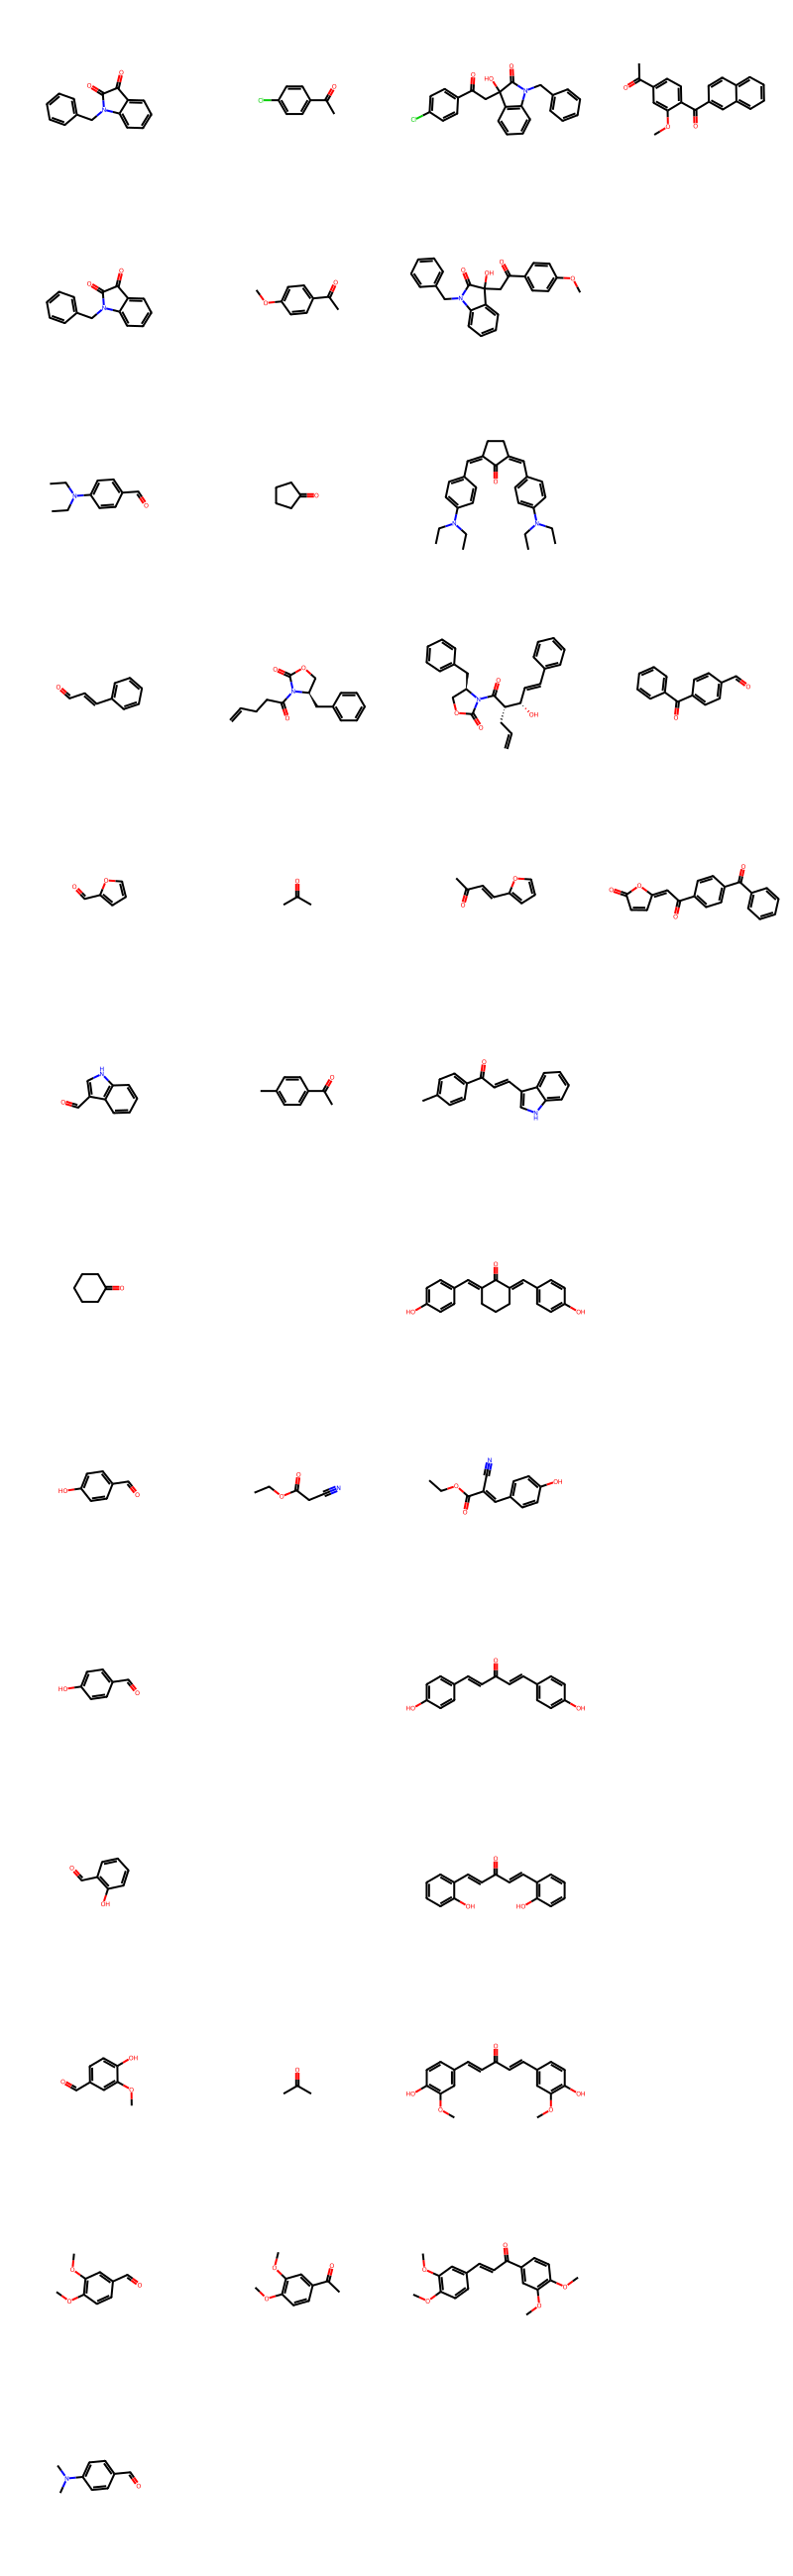

In [1288]:
mol_grids = []


# List to hold all molecule objects across rows
all_mols = []

empty_mol = Chem.MolFromSmiles('')

# List to hold all molecule objects across rows
all_mols = []

empty_mol = None  # Use None to represent a blank placeholder for invalid molecules

# List to hold all molecule objects across rows
all_mols = []

# Iterate through each row in the DataFrame
for index, row in df_cond_comparaison.iterrows():
    # Convert SMILES strings to RDKit Molecule objects, replace invalid SMILES with None
    mols = [Chem.MolFromSmiles(smiles) if isinstance(smiles, str) and pd.notnull(smiles) else empty_mol for smiles in row]
    
    # Ensure every row has exactly 4 molecules (either valid or blank)
    all_mols.extend(mols)  # Adding molecules from this row into the combined list

# Now create the final 30x4 matrix of molecules (with placeholders for invalid ones)
if len(all_mols) > 0:
    # Create the final grid of molecules (4 molecules per row)
    final_img = Draw.MolsToGridImage([mol for mol in all_mols], molsPerRow=4, subImgSize=(200, 200))  # 4 molecules per row
    display(final_img)  # Use IPython's display function for Jupyter Notebooks
else:
    print("No valid molecules to display.")